In [3]:
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)


In [4]:
import xarray as xr

# This will NOT load everything into memory!
ds = xr.open_mfdataset('merge_20*.nc', combine='by_coords', chunks={'time': 10})

print(ds)


<xarray.Dataset> Size: 2GB
Dimensions:                    (time: 662, bnds: 2, lon: 401, lat: 351)
Coordinates:
  * lon                        (lon) float32 2kB 60.05 60.15 ... 99.95 100.1
  * lat                        (lat) float32 1kB 4.95 5.05 5.15 ... 39.85 39.95
  * time                       (time) datetime64[ns] 5kB 2014-06-01 ... 2019-...
Dimensions without coordinates: bnds
Data variables:
    time_bnds                  (time, bnds) datetime64[ns] 11kB dask.array<chunksize=(10, 2), meta=np.ndarray>
    precipitationCal           (time, lon, lat) float32 373MB dask.array<chunksize=(10, 401, 163), meta=np.ndarray>
    HQprecipitation            (time, lon, lat) float32 373MB dask.array<chunksize=(10, 401, 163), meta=np.ndarray>
    precipitationCal_cnt       (time, lon, lat) int16 186MB dask.array<chunksize=(10, 401, 163), meta=np.ndarray>
    randomError                (time, lon, lat) float32 373MB dask.array<chunksize=(10, 401, 163), meta=np.ndarray>
    randomError_cnt     

In [5]:
# Pick a grid cell (e.g., central India)
lat_sel = 20.0
lon_sel = 80.0

# Find nearest grid indices
lat_idx = ds['lat'].sel(lat=lat_sel, method='nearest').item()
lon_idx = ds['lon'].sel(lon=lon_sel, method='nearest').item()

# Extract time series
rain_ts = ds['precipitationCal'].sel(lat=lat_sel, lon=lon_sel, method='nearest').compute()
rain_df = rain_ts.to_dataframe().reset_index()


In [6]:
# Select the grid cell nearest to the specified latitude and longitude
lat_sel = 20.0
lon_sel = 80.0

# Extract the time series for that grid cell
rain_ts = ds['precipitationCal'].sel(lat=lat_sel, lon=lon_sel, method='nearest').compute()

# Convert to DataFrame
rain_df = rain_ts.to_dataframe().reset_index()

# Show the first few rows
print(rain_df.head())


        time        lon        lat  precipitationCal
0 2014-06-01  80.050003  20.049999          0.143161
1 2014-06-02  80.050003  20.049999          0.746668
2 2014-06-03  80.050003  20.049999          0.000389
3 2014-06-04  80.050003  20.049999          0.000000
4 2014-06-05  80.050003  20.049999          0.000000


In [7]:
import xarray as xr
import numpy as np
from scipy.ndimage import label

# --- Load your dataset (already loaded as 'ds' in your session) ---
# ds = xr.open_dataset('your_merged_file.nc')  # Uncomment if not already loaded

# --- Select the date of interest ---
date_of_interest = '2019-08-07'
rain = ds['precipitationCal'].sel(time=date_of_interest)

# --- Ensure rainfall is (lat, lon) order ---
if rain.dims != ('lat', 'lon'):
    rain = rain.transpose('lat', 'lon')

# --- Threshold for heavy rain (e.g., >50 mm) ---
rain_mask = (rain > 50)

# --- Label contiguous regions (blobs) ---
labeled_array, num_features = label(rain_mask)

# --- Calculate grid cell area (in km^2) for each grid point ---
lat = ds['lat'].values
lon = ds['lon'].values

# Earth's radius in km
R = 6371.0
lat_res = np.abs(lat[1] - lat[0])
lon_res = np.abs(lon[1] - lon[0])
lat_rad = np.deg2rad(lat)
delta_lat_rad = np.deg2rad(lat_res)
delta_lon_rad = np.deg2rad(lon_res)
area_per_lat = (R**2) * delta_lat_rad * delta_lon_rad * np.cos(lat_rad)
grid_cell_area = np.repeat(area_per_lat[:, np.newaxis], len(lon), axis=1)  # (lat, lon)

# --- Loop through each labeled region and compute area and mean rainfall ---
found = False
for i in range(1, num_features+1):
    region = (labeled_array == i)
    area = np.sum(grid_cell_area[region])  # total area in km^2 for this region
    mean_rain = rain.values[region].mean()
    if area > 50000 and mean_rain > 50:  # example thresholds
        print(f"Possible TC/Depression detected on {date_of_interest}:")
        print(f"  - Region label: {i}")
        print(f"  - Area: {area:.2f} km^2")
        print(f"  - Mean rainfall: {mean_rain:.2f} mm")
        found = True

if not found:
    print(f"No TC/Depression-like rainfall region detected on {date_of_interest}.")



Possible TC/Depression detected on 2019-08-07:
  - Region label: 1
  - Area: 75151.60 km^2
  - Mean rainfall: 91.50 mm
Possible TC/Depression detected on 2019-08-07:
  - Region label: 28
  - Area: 119458.58 km^2
  - Mean rainfall: 75.07 mm
Possible TC/Depression detected on 2019-08-07:
  - Region label: 33
  - Area: 67987.42 km^2
  - Mean rainfall: 106.54 mm
Possible TC/Depression detected on 2019-08-07:
  - Region label: 48
  - Area: 257608.64 km^2
  - Mean rainfall: 81.88 mm


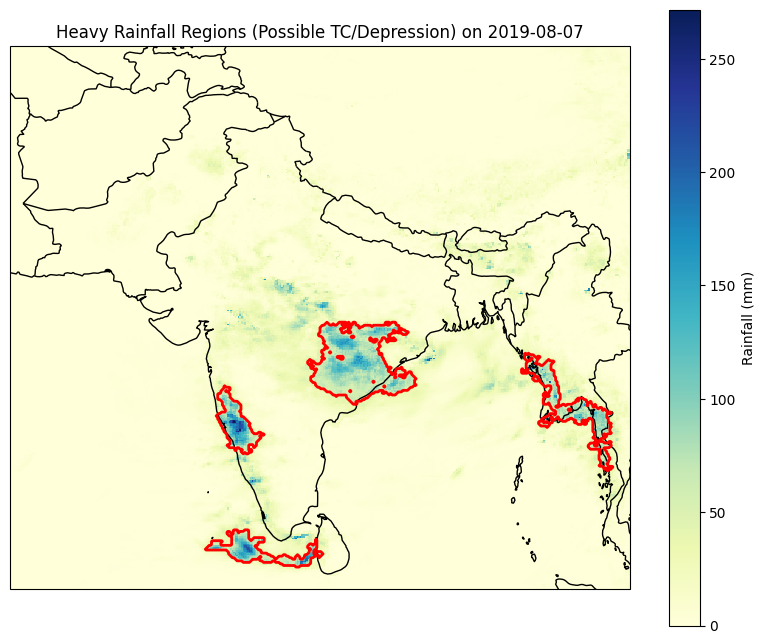

In [8]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Plot the rainfall field and overlay detected regions
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot rainfall
rain_plot = rain.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='YlGnBu', cbar_kwargs={'label': 'Rainfall (mm)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_extent([60, 100, 5, 40], crs=ccrs.PlateCarree())
ax.set_title(f'Heavy Rainfall Regions (Possible TC/Depression) on {date_of_interest}')

# Overlay detected regions
for i in [1, 28, 33, 48]:  # Use the region labels you found
    region = (labeled_array == i)
    # Plot the region boundary
    ax.contour(lon, lat, region, levels=[0.5], colors='red', linewidths=2, transform=ccrs.PlateCarree())

plt.show()


In [9]:
import pandas as pd
df = rain_df.copy()
for lag in range(1, 8):
    df[f'rain_lag_{lag}'] = df['precipitationCal'].shift(lag)
df = df.dropna()


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(['time', 'precipitationCal'], axis=1).values
y = df['precipitationCal'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


In [11]:
# CORRECTED CODE
from sklearn.ensemble import RandomForestRegressor  # <-- ADD THIS LINE
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
print("R²:", r2_score(y_test, y_pred))


RMSE: 20.94071079300957
R²: 0.03560202589183825


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [13]:
print(df.columns)


Index(['time', 'lon', 'lat', 'precipitationCal', 'rain_lag_1', 'rain_lag_2',
       'rain_lag_3', 'rain_lag_4', 'rain_lag_5', 'rain_lag_6', 'rain_lag_7'],
      dtype='object')


In [14]:
# Example: Load data from CSV
# df = pd.read_csv('your_rainfall_data.csv')

# For demonstration, let's say your DataFrame has columns:
# ['rainfall', 'temp', 'humidity', 'wind', 'pressure', ...]

# Drop rows with missing values
df = df.dropna()
# Drop non-feature columns and the target column for X
X = df.drop(['time', 'lon', 'lat', 'precipitationCal'], axis=1).values
y = df['precipitationCal'].values



In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [16]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [17]:
y_pred = model.predict(X_test)


In [18]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE:", rmse)
print("R2:", r2)


RMSE: 21.392569692846582
R2: 0.05374188429054216


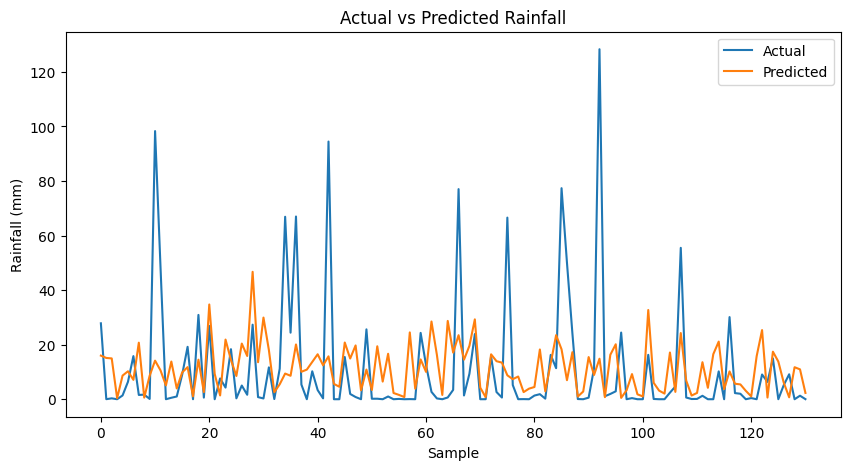

In [19]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Rainfall')
plt.xlabel('Sample')
plt.ylabel('Rainfall (mm)')
plt.show()


In [20]:
import numpy as np
import xarray as xr

# Example: Assume you have rainfall data for three consecutive days
dates = ['2019-08-05', '2019-08-06', '2019-08-07']
centroids = []

for date in dates:
    rain = ds['precipitationCal'].sel(time=date)
    if rain.dims != ('lat', 'lon'):
        rain = rain.transpose('lat', 'lon')
    rain_mask = (rain > 50)  # threshold for heavy rain

    # Find centroid of heavy rain region
    lat_vals = ds['lat'].values
    lon_vals = ds['lon'].values
    mask = rain_mask.values
    if np.any(mask):
        y_idx, x_idx = np.where(mask)
        centroid_lat = np.mean(lat_vals[y_idx])
        centroid_lon = np.mean(lon_vals[x_idx])
        centroids.append((centroid_lat, centroid_lon))
    else:
        centroids.append((np.nan, np.nan))

# Calculate motion vector (mean daily movement)
if len(centroids) == 3 and not any(np.isnan(c).any() for c in centroids):
    delta_lat1 = centroids[1][0] - centroids[0][0]
    delta_lon1 = centroids[1][1] - centroids[0][1]
    delta_lat2 = centroids[2][0] - centroids[1][0]
    delta_lon2 = centroids[2][1] - centroids[1][1]
    mean_delta_lat = (delta_lat1 + delta_lat2) / 2
    mean_delta_lon = (delta_lon1 + delta_lon2) / 2

    # Extrapolate to next day
    pred_lat = centroids[2][0] + mean_delta_lat
    pred_lon = centroids[2][1] + mean_delta_lon

    print(f"Predicted centroid for next day: lat={pred_lat:.2f}, lon={pred_lon:.2f}")
else:
    print("Not enough valid centroids to extrapolate.")


Predicted centroid for next day: lat=17.60, lon=81.13


RMSE: 21.392569692846582
R2: 0.05374188429054216


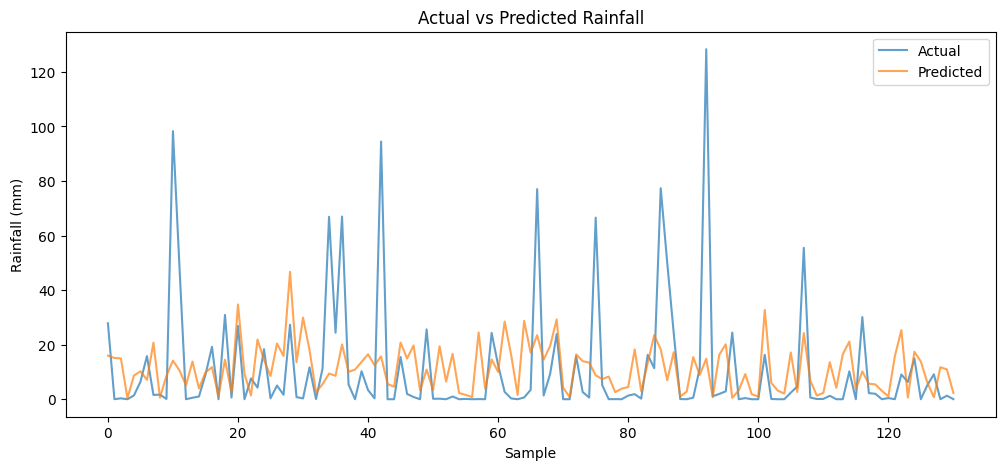

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Example: y_test and y_pred are your actual and predicted rainfall arrays

# Numerical evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("RMSE:", rmse)
print("R2:", r2)

# Line plot comparison
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Sample')
plt.ylabel('Rainfall (mm)')
plt.title('Actual vs Predicted Rainfall')
plt.legend()
plt.show()


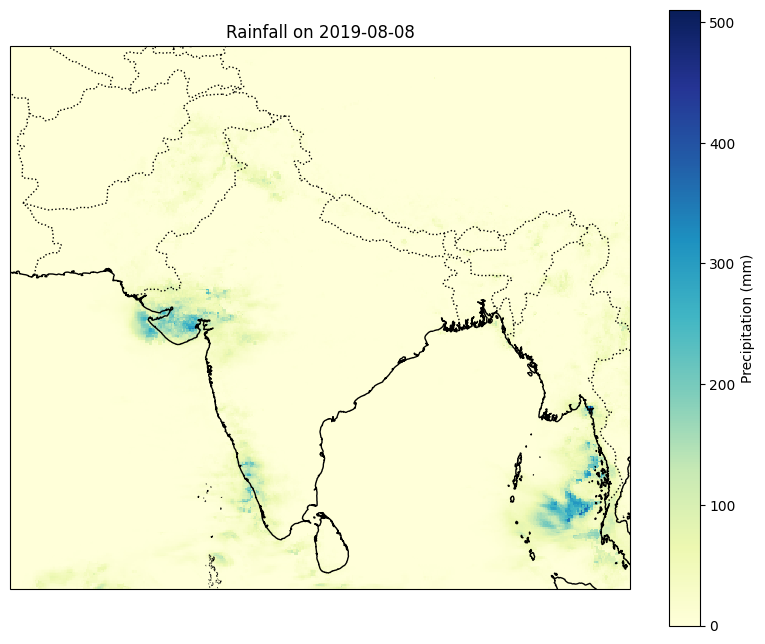

In [22]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ds = xr.open_mfdataset('merge_20*.nc', combine='by_coords')
ds = ds.groupby('time').first()
date_of_interest = '2019-08-08'
rain = ds['precipitationCal'].sel(time=date_of_interest, method='nearest').transpose('lat', 'lon')

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
rain.plot(ax=ax, cmap='YlGnBu', cbar_kwargs={'label': 'Precipitation (mm)'})
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.set_title(f'Rainfall on {date_of_interest}')
plt.show()


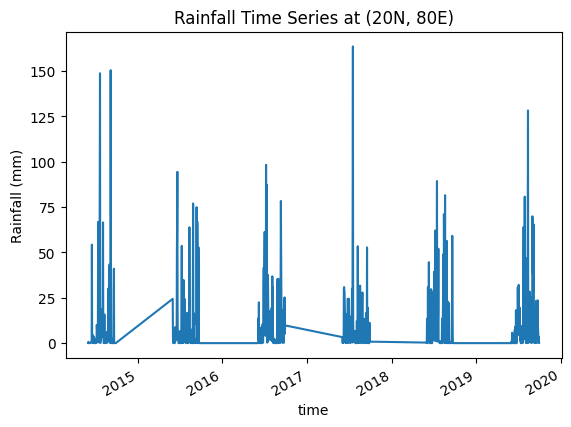

In [23]:
# Example: Central India (lat=20, lon=80)
ts = ds['precipitationCal'].sel(lat=20, lon=80, method='nearest').to_pandas()
ts.plot(title='Rainfall Time Series at (20N, 80E)')
plt.ylabel('Rainfall (mm)')
plt.show()


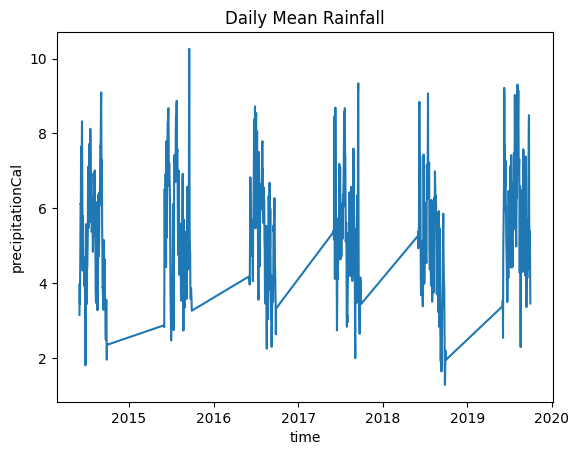

In [24]:
# Daily spatial mean rainfall
mean_rain = ds['precipitationCal'].mean(dim=['lat', 'lon'])
mean_rain.plot()
plt.title('Daily Mean Rainfall')
plt.show()


In [25]:
import pandas as pd
df = ts.reset_index().rename(columns={'precipitationCal': 'rainfall'})
for lag in range(1, 8):
    df[f'rain_lag_{lag}'] = df['rainfall'].shift(lag)
df['month'] = df['time'].dt.month
df = df.dropna()


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X = df.drop(['time', 'rainfall'], axis=1).values
y = df['rainfall'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))


RMSE: 21.05934976572307
R2: -0.030822869608689407


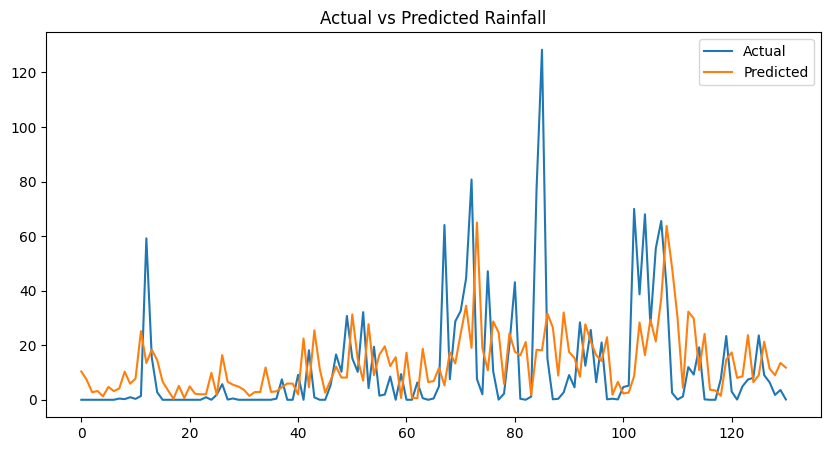

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Rainfall')
plt.show()


In [28]:
print(df.columns)


Index(['time', 'rainfall', 'rain_lag_1', 'rain_lag_2', 'rain_lag_3',
       'rain_lag_4', 'rain_lag_5', 'rain_lag_6', 'rain_lag_7', 'month'],
      dtype='object')


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# Load your DataFrame `df` (assuming it's preprocessed with lagged features)
# Ensure 'time' and 'precipitationCal' are available
# Define features (X) and target (y)
X = df.drop(['time', 'rainfall'], axis=1).values
y = df['rainfall'].values

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary of models to compare
models = {
    'Linear Regression': LinearRegression(),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5),
    'Support Vector Regressor': SVR(kernel='rbf'),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((name, rmse, r2))
    print(f"{name} -> RMSE: {rmse:.3f}, R²: {r2:.3f}")

# Convert results to DataFrame for better display
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R2"])
results_df = results_df.sort_values(by="RMSE")
print("\nComparison Table:\n", results_df)


Linear Regression -> RMSE: 18.545, R²: 0.099
KNN Regressor -> RMSE: 19.672, R²: -0.014
Support Vector Regressor -> RMSE: 20.513, R²: -0.102
Gradient Boosting -> RMSE: 20.727, R²: -0.125
Random Forest -> RMSE: 19.833, R²: -0.030

Comparison Table:
                       Model       RMSE        R2
0         Linear Regression  18.544628  0.099162
1             KNN Regressor  19.672105 -0.013707
4             Random Forest  19.833159 -0.030373
2  Support Vector Regressor  20.512990 -0.102221
3         Gradient Boosting  20.727262 -0.125368


In [30]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 1. Load dataset (already loaded as 'ds')
# ds = xr.open_mfdataset('merge_20*.nc', combine='by_coords', chunks={'time': 10})

# 2. Select grid cell (e.g., Central India)
lat_sel = 20.0
lon_sel = 80.0
rain_ts = ds['precipitationCal'].sel(lat=lat_sel, lon=lon_sel, method='nearest').compute()
rain_df = rain_ts.to_dataframe().reset_index()

# 3. Feature engineering: create lagged rainfall features
def create_lagged_features(df, lag_days=7):
    for lag in range(1, lag_days+1):
        df[f'lag_{lag}'] = df['precipitationCal'].shift(lag)
    df = df.dropna().reset_index(drop=True)
    return df

rain_df = create_lagged_features(rain_df, lag_days=7)

# 4. Prepare data for ML
X = rain_df[[f'lag_{i}' for i in range(1, 8)]].values
y = rain_df['precipitationCal'].values

# 5. Train/test split
split_idx = int(0.8 * len(rain_df))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# 6. Train Random Forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 7. Predict and evaluate
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.3f}")


Test MSE: 437.789


In [31]:
import xarray as xr
import numpy as np
from scipy.ndimage import label

# 1. Select date of interest
date_of_interest = '2019-08-01'
rain = ds['precipitationCal'].sel(time=date_of_interest)

# 2. Ensure (lat, lon) order
if rain.dims != ('lat', 'lon'):
    rain = rain.transpose('lat', 'lon')

# 3. Threshold for heavy rain (e.g., >50 mm)
rain_mask = (rain > 50)

# 4. Label contiguous regions
labeled_array, num_features = label(rain_mask)

# 5. Compute grid cell area (in km^2)
lat = ds['lat'].values
lon = ds['lon'].values
R = 6371.0  # Earth's radius in km
lat_res = np.abs(lat[1] - lat[0])
lon_res = np.abs(lon[1] - lon[0])
lat_rad = np.deg2rad(lat)
delta_lat_rad = np.deg2rad(lat_res)
delta_lon_rad = np.deg2rad(lon_res)
area_per_lat = (R**2) * delta_lat_rad * delta_lon_rad * np.cos(lat_rad)
grid_cell_area = np.repeat(area_per_lat[:, np.newaxis], len(lon), axis=1)

# 6. Loop through labeled regions
for i in range(1, num_features+1):
    region = (labeled_array == i)
    area = np.sum(grid_cell_area[region])
    mean_rain = rain.values[region].mean()
    if area > 50000 and mean_rain > 50:  # Example thresholds
        print(f"Possible TC/Depression detected on {date_of_interest}:")
        print(f" - Region label: {i}")
        print(f" - Area: {area:.2f} km^2")
        print(f" - Mean rainfall: {mean_rain:.2f} mm")


Possible TC/Depression detected on 2019-08-01:
 - Region label: 8
 - Area: 69602.38 km^2
 - Mean rainfall: 86.87 mm
Possible TC/Depression detected on 2019-08-01:
 - Region label: 11
 - Area: 68802.16 km^2
 - Mean rainfall: 79.39 mm


In [32]:
import pandas as pd
df = pd.read_excel('c08063_Best Tracks__Data (1982-2024).xlsx', engine='openpyxl')
print(df.head())


   Serial Number of system during year Basin of origin  Name Date(DD-MM-YYYY)  \
0                                  1.0             BOB   NaN       1982-05-01   
1                                  1.0             BOB   NaN       1982-05-01   
2                                  1.0             BOB   NaN       1982-05-01   
3                                  1.0             BOB   NaN       1982-05-01   
4                                  1.0             BOB   NaN       1982-05-02   

  Time (UTC) Latitude (lat.)  Longitude (lon.) CI No [or "T. No"]  \
0       0300            14.0              82.5                1.5   
1       0600            14.5              82.5                2.0   
2       1200            15.0              82.0                2.5   
3       1800            15.5              82.5                2.5   
4       0000            16.0              83.0                3.0   

   Estimated Central Pressure (hPa) [or "E.C.P"]  \
0                                            N

In [33]:
# Filter for Deep Depressions (DD)
dd_df = df[df['Grade (text)'] == 'DD']

# Filter for Cyclonic Storms (CS), Severe Cyclonic Storms (SCS), etc.
tc_grades = ['CS', 'SCS', 'VSCS', 'ESCS', 'SuCS', 'SC', 'TC']
tc_df = df[df['Grade (text)'].isin(tc_grades)]


In [34]:
import pandas as pd

# Read your Excel file
df = pd.read_excel('c08063_Best Tracks__Data (1982-2024).xlsx', engine='openpyxl')

# Check the actual column names
print("Column names in your DataFrame:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())


Column names in your DataFrame:
['Serial Number of system during year', 'Basin of origin', 'Name', 'Date(DD-MM-YYYY)', 'Time (UTC)', 'Latitude (lat.)', 'Longitude (lon.)', 'CI No [or "T. No"]', 'Estimated Central Pressure (hPa) [or "E.C.P"]', 'Maximum Sustained Surface Wind (kt) ', 'Pressure Drop (hPa)[or "delta P"]', 'Grade (text)', 'Outermost closed isobar (hPa)', 'Diameter/Size of outermost closed isobar']

First few rows:
   Serial Number of system during year Basin of origin  Name Date(DD-MM-YYYY)  \
0                                  1.0             BOB   NaN       1982-05-01   
1                                  1.0             BOB   NaN       1982-05-01   
2                                  1.0             BOB   NaN       1982-05-01   
3                                  1.0             BOB   NaN       1982-05-01   
4                                  1.0             BOB   NaN       1982-05-02   

  Time (UTC) Latitude (lat.)  Longitude (lon.) CI No [or "T. No"]  \
0       0300  

In [35]:
import pandas as pd

df = pd.read_excel('c08063_Best Tracks__Data (1982-2024).xlsx', engine='openpyxl')
print(df.columns.tolist())


['Serial Number of system during year', 'Basin of origin', 'Name', 'Date(DD-MM-YYYY)', 'Time (UTC)', 'Latitude (lat.)', 'Longitude (lon.)', 'CI No [or "T. No"]', 'Estimated Central Pressure (hPa) [or "E.C.P"]', 'Maximum Sustained Surface Wind (kt) ', 'Pressure Drop (hPa)[or "delta P"]', 'Grade (text)', 'Outermost closed isobar (hPa)', 'Diameter/Size of outermost closed isobar']


In [36]:
import pandas as pd
import numpy as np

# Read the data
df = pd.read_excel('c08063_Best Tracks__Data (1982-2024).xlsx', engine='openpyxl')

# Check data types and sample values
print("Longitude column info:")
print(df['Longitude (lon.)'].dtype)
print(df['Longitude (lon.)'].head(10))
print("\nLatitude column info:")
print(df['Latitude (lat.)'].dtype)
print(df['Latitude (lat.)'].head(10))

# Check for non-numeric values
print("\nUnique non-numeric values in Longitude:")
print(df['Longitude (lon.)'][pd.to_numeric(df['Longitude (lon.)'], errors='coerce').isna()].unique())


Longitude column info:
float64
0    82.5
1    82.5
2    82.0
3    82.5
4    83.0
5    83.5
6    84.0
7    84.5
8    85.0
9    86.0
Name: Longitude (lon.), dtype: float64

Latitude column info:
object
0    14.0
1    14.5
2    15.0
3    15.5
4    16.0
5    16.5
6    16.5
7    16.5
8    17.0
9    17.0
Name: Latitude (lat.), dtype: object

Unique non-numeric values in Longitude:
[nan]


In [37]:
# Clean and convert to numeric
df['Longitude (lon.)'] = pd.to_numeric(df['Longitude (lon.)'], errors='coerce')
df['Latitude (lat.)'] = pd.to_numeric(df['Latitude (lat.)'], errors='coerce')

# Remove rows with missing coordinates
df = df.dropna(subset=['Longitude (lon.)', 'Latitude (lat.)'])

# Check the cleaned data
print("After cleaning:")
print(f"Longitude range: {df['Longitude (lon.)'].min()} to {df['Longitude (lon.)'].max()}")
print(f"Latitude range: {df['Latitude (lat.)'].min()} to {df['Latitude (lat.)'].max()}")


After cleaning:
Longitude range: 65.0 to 98.5
Latitude range: 7.0 to 26.0


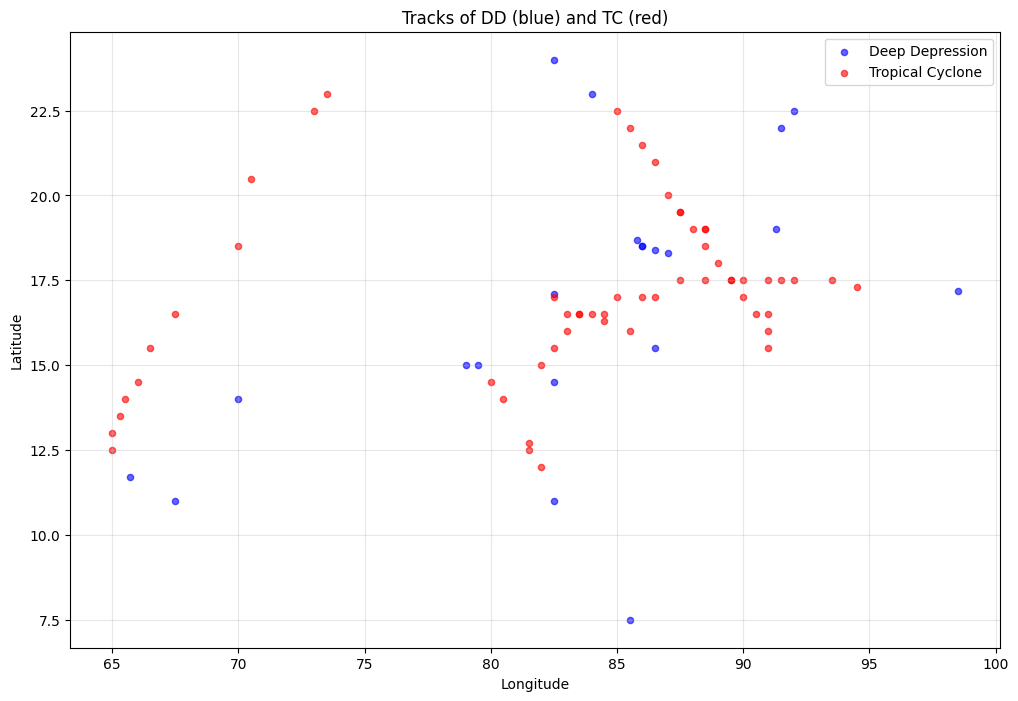

Total DD points: 21
Total TC points: 57


In [38]:
import matplotlib.pyplot as plt

# Filter for Deep Depressions (DD)
dd_df = df[df['Grade (text)'] == 'DD']

# Filter for Cyclonic Storms and stronger
tc_grades = ['CS', 'SCS', 'VSCS', 'ESCS', 'SuCS']
tc_df = df[df['Grade (text)'].isin(tc_grades)]

# Plot
plt.figure(figsize=(12, 8))
if not dd_df.empty:
    plt.scatter(dd_df['Longitude (lon.)'], dd_df['Latitude (lat.)'], 
                c='blue', label='Deep Depression', alpha=0.6, s=20)
if not tc_df.empty:
    plt.scatter(tc_df['Longitude (lon.)'], tc_df['Latitude (lat.)'], 
                c='red', label='Tropical Cyclone', alpha=0.6, s=20)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Tracks of DD (blue) and TC (red)')
plt.grid(True, alpha=0.3)
plt.show()

# Print summary
print(f"Total DD points: {len(dd_df)}")
print(f"Total TC points: {len(tc_df)}")


In [39]:
import pandas as pd

# Load and clean data
df = pd.read_excel('c08063_Best Tracks__Data (1982-2024).xlsx', engine='openpyxl')

# Rename for convenience
df = df.rename(columns={
    'Latitude (lat.)': 'lat',
    'Longitude (lon.)': 'lon',
    'Grade (text)': 'grade',
    'Date(DD-MM-YYYY)': 'date',
    'Serial Number of system during year': 'serial'
})

# Ensure proper type
df['grade'] = df['grade'].astype(str)
df['serial'] = df['serial'].astype(str)


In [40]:
TC_grades = ['CS', 'SCS', 'VSCS', 'ESCS', 'SuCS']


In [41]:
# Group by unique system (serial number, or use both serial and year if needed)
system_groups = df.groupby('serial')

tc_count = 0
dd_only_count = 0

for serial, group in system_groups:
    grades = group['grade'].tolist()
    # If system ever reaches TC grade, count as TC
    if any(g in TC_grades for g in grades):
        tc_count += 1
    # If system never reaches TC grade, but has at least one DD or D, count as DD
    elif any(g in ['DD', 'D'] for g in grades):
        dd_only_count += 1

print(f"Number of systems that became TC: {tc_count}")
print(f"Number of systems that remained DD/D: {dd_only_count}")


Number of systems that became TC: 5
Number of systems that remained DD/D: 13


In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Read your Excel file
file_path = 'c08063_Best Tracks__Data (1982-2024).xlsx'
df = pd.read_excel(file_path, engine='openpyxl')

# Rename columns for easy access
df = df.rename(columns={
    'Latitude (lat.)': 'lat',
    'Longitude (lon.)': 'lon',
    'Grade (text)': 'grade',
    'Date(DD-MM-YYYY)': 'date',
    'Serial Number of system during year': 'serial'
})

# Clean coordinates
df['lat'] = pd.to_numeric(df['lat'], errors='coerce')
df['lon'] = pd.to_numeric(df['lon'], errors='coerce')
df = df.dropna(subset=['lat', 'lon'])


In [43]:
TC_grades = ['CS', 'SCS', 'VSCS', 'ESCS', 'SuCS']
system_groups = df.groupby('serial')

tc_origins = []
dd_origins = []

for serial, group in system_groups:
    grades = group['grade'].tolist()
    # Use the first position as the origin
    origin_lat = group['lat'].iloc[0]
    origin_lon = group['lon'].iloc[0]
    if any(g in TC_grades for g in grades):
        tc_origins.append((origin_lon, origin_lat))
    elif any(g in ['DD', 'D'] for g in grades):
        dd_origins.append((origin_lon, origin_lat))

print(f"Number of cyclones (TC): {len(tc_origins)}")
print(f"Number of depressions (DD/D only): {len(dd_origins)}")


Number of cyclones (TC): 5
Number of depressions (DD/D only): 13


In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input

# --- Model Inputs ---
# X_seq: (batch, time_steps, height, width, channels) - e.g., sequence of precipitation maps
# y_track: (batch, 2) - next cyclone center [lat, lon]
# y_intensity: (batch, 1) - next intensity (e.g., wind speed or rainfall)

input_seq = Input(shape=(10, 64, 64, 1), name='precip_sequence')  # Adjust shape as needed

# CNN layers to extract spatial features for each time step
cnn = layers.TimeDistributed(layers.Conv2D(32, (3,3), activation='relu'))(input_seq)
cnn = layers.TimeDistributed(layers.MaxPooling2D((2,2)))(cnn)
cnn = layers.TimeDistributed(layers.Conv2D(64, (3,3), activation='relu'))(cnn)
cnn = layers.TimeDistributed(layers.MaxPooling2D((2,2)))(cnn)
cnn = layers.TimeDistributed(layers.Flatten())(cnn)

# LSTM to capture temporal dependencies
lstm = layers.LSTM(64, activation='tanh')(cnn)

# Output branches
track_output = layers.Dense(2, activation='linear', name='track_output')(lstm)       # Predict next lat/lon
intensity_output = layers.Dense(1, activation='linear', name='intensity_output')(lstm)  # Predict next intensity

# Build and compile the model
model = models.Model(inputs=input_seq, outputs=[track_output, intensity_output])
model.compile(
    optimizer='adam',
    loss={'track_output': 'mse', 'intensity_output': 'mse'},
    metrics={'track_output': 'mae', 'intensity_output': 'mae'}
)

model.summary()

# Example training call (replace X_seq, y_track, y_intensity with your data)
# model.fit(X_seq, {'track_output': y_track, 'intensity_output': y_intensity}, batch_size=16, epochs=50, validation_split=0.2)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ precip_sequence     │ (None, 10, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 10, 62,    │        320 │ precip_sequence[… │
│ (TimeDistributed)   │ 62, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 10, 31,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 31, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 10, 29,    │     18,496 │ time_distributed… │
│ (TimeDistributed)   │ 29, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 10, 14,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 14, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 10, 12544) │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │  3,227,904 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ track_output        │ (None, 2)         │        130 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ intensity_output    │ (None, 1)         │         65 │ lstm[0][0]        │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,246,915 (12.39 MB)

 Trainable params: 3,246,915 (12.39 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# import numpy as np

# # Example: Load or prepare your real-time precipitation sequence
# # X_new shape: (batch_size=1, time_steps=10, height=64, width=64, channels=1)
# # Replace this with real data loading in practice
# X_new = np.random.rand(1, 10, 64, 64, 1).astype(np.float32)


In [46]:
# import numpy as np

# # Example: 100 samples, 10 time steps, 64x64 grid, 1 channel
# X_train = np.random.rand(20, 5, 32, 32, 1).astype(np.float32)
# y_track_train = np.random.uniform(low=[10, 70], high=[30, 90], size=(100, 2)).astype(np.float32)  # e.g., lat/lon
# y_intensity_train = np.random.uniform(low=20, high=120, size=(100, 1)).astype(np.float32)         # e.g., wind speed


In [47]:
# import tensorflow as tf
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)

# from tensorflow.keras import layers, models
# import numpy as np

# # Simulated small dataset
# X_train = np.random.rand(20, 10, 64, 64, 1).astype(np.float32)
# y_track = np.random.rand(20, 2).astype(np.float32)
# y_intensity = np.random.rand(20, 1).astype(np.float32)

# # Simple model for demonstration
# input_layer = layers.Input(shape=(10, 64, 64, 1))
# x = layers.Conv3D(8, (3, 3, 3), activation='relu')(input_layer)
# x = layers.GlobalAveragePooling3D()(x)

# track_output = layers.Dense(2, name="track_output")(x)
# intensity_output = layers.Dense(1, name="intensity_output")(x)

# model = models.Model(inputs=input_layer, outputs=[track_output, intensity_output])
# model.compile(optimizer='adam', loss='mse')

# model.summary()
# model.fit(X_train, {"track_output": y_track, "intensity_output": y_intensity}, epochs=1)


In [48]:
import numpy as np

# Example dataset: 20 samples, 10 time steps, 64x64 grid, 1 channel
X_train = np.random.rand(20, 10, 64, 64, 1).astype(np.float32)
y_track = np.random.uniform(low=[10, 70], high=[30, 90], size=(20, 2)).astype(np.float32)
y_intensity = np.random.uniform(low=20, high=120, size=(20, 1)).astype(np.float32)



In [49]:
from tensorflow.keras import layers, models

input_layer = layers.Input(shape=(10, 64, 64, 1))
x = layers.Conv3D(8, (3, 3, 3), activation='relu')(input_layer)
x = layers.GlobalAveragePooling3D()(x)

# Two outputs: track (2D) and intensity (1D)
track_output = layers.Dense(2, name='track_output')(x)
intensity_output = layers.Dense(1, name='intensity_output')(x)

model = models.Model(inputs=input_layer, outputs=[track_output, intensity_output])
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 8, 62, 62, │        224 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 8)         │          0 │ conv3d[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ track_output        │ (None, 2)         │         18 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ intensity_output    │ (None, 1)         │          9 │ global_average_p… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 251 (1004.00 B)

 Trainable params: 251 (1004.00 B)

 Non-trainable params: 0 (0.00 B)

In [50]:
model.fit(
    X_train,
    {'track_output': y_track, 'intensity_output': y_intensity},
    epochs=5
)


Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - intensity_output_loss: 5971.1523 - loss: 9356.7109 - track_output_loss: 3385.5591
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - intensity_output_loss: 5966.4409 - loss: 9351.5078 - track_output_loss: 3385.0671
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - intensity_output_loss: 5961.8271 - loss: 9346.3418 - track_output_loss: 3384.5142
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - intensity_output_loss: 5957.3174 - loss: 9341.2168 - track_output_loss: 3383.8999
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - intensity_output_loss: 5952.9150 - loss: 9336.1416 - track_output_loss: 3383.2266


In [51]:
x = layers.Conv3D(8, (3, 3, 3), activation='relu')(input_layer)
x = layers.Conv3D(16, (3, 3, 3), activation='relu')(x)
x = layers.MaxPooling3D((2, 2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)



In [52]:
history = model.fit(
    X_train,
    {'track_output': y_track, 'intensity_output': y_intensity},
    epochs=20
)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - intensity_output_loss: 5948.6196 - loss: 9331.1143 - track_output_loss: 3382.4946
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - intensity_output_loss: 5944.4302 - loss: 9326.1367 - track_output_loss: 3381.7070
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - intensity_output_loss: 5940.3423 - loss: 9321.2080 - track_output_loss: 3380.8657
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - intensity_output_loss: 5936.3491 - loss: 9316.3223 - track_output_loss: 3379.9734
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - intensity_output_loss: 5932.4448 - loss: 9311.4785 - track_output_loss: 3379.0339
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - intensity_output_loss: 5928.6206 - loss: 9306.6699 - track_output_loss: 3378.0496
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - intensity_output_loss: 5924.8662 - loss: 9301.8896 - track_output_loss: 3377.0234
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - intensity_

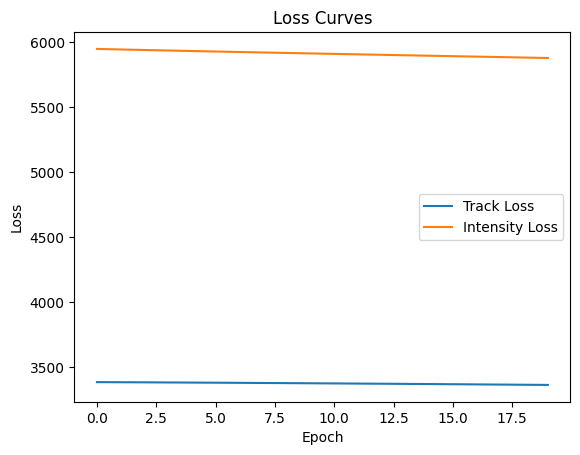

In [53]:
import matplotlib.pyplot as plt

plt.plot(history.history['track_output_loss'], label='Track Loss')
plt.plot(history.history['intensity_output_loss'], label='Intensity Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [54]:
print(X_test.shape)


(131, 7)


In [55]:
print(X_train.shape)


(20, 10, 64, 64, 1)


In [56]:
X_test = np.random.rand(5, 10, 64, 64, 1).astype(np.float32)  # for 5 test samples



In [57]:
import numpy as np

# Generate 20 samples of synthetic 64x64 image sequences (10 time steps)
X_train = np.random.rand(20, 10, 64, 64, 1).astype(np.float32)

# 20 samples of cyclone track (lat, lon)
y_track = np.random.uniform(low=[10, 70], high=[30, 90], size=(20, 2)).astype(np.float32)

# 20 samples of cyclone intensity
y_intensity = np.random.uniform(low=20, high=120, size=(20, 1)).astype(np.float32)

# Now all shapes match: 20 samples
model.fit(X_train, {'track_output': y_track, 'intensity_output': y_intensity}, epochs=20)



Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - intensity_output_loss: 5370.4224 - loss: 8776.0596 - track_output_loss: 3405.6375
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - intensity_output_loss: 5366.9561 - loss: 8771.1436 - track_output_loss: 3404.1875
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - intensity_output_loss: 5363.4771 - loss: 8766.1953 - track_output_loss: 3402.7188
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - intensity_output_loss: 5359.9829 - loss: 8761.2148 - track_output_loss: 3401.2319
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - intensity_output_loss: 5356.4717 - loss: 8756.1973 - track_output_loss: 3399.7261
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - intensity_output_loss: 5352.9438 - loss: 8751.1465 - track_output_loss: 3398.2024
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - intensity_output_loss: 5349.3960 - loss: 8746.0557 - track_output_loss: 3396.6597
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - intensity_

In [58]:
print("X_train:", X_train.shape)
print("y_track:", y_track.shape)
print("y_intensity:", y_intensity.shape)


X_train: (20, 10, 64, 64, 1)
y_track: (20, 2)
y_intensity: (20, 1)


In [59]:
predictions = model.predict(X_test)
track_pred = predictions[0]         # Shape: (5, 2)
intensity_pred = predictions[1]     # Shape: (5, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


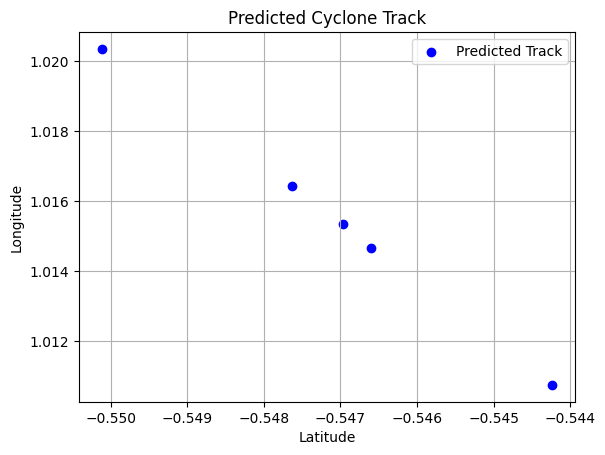

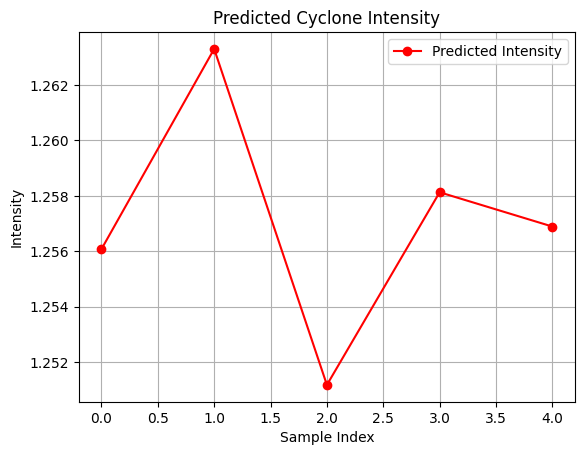

In [60]:
import matplotlib.pyplot as plt

# Plot predicted track (latitude vs. longitude)
plt.scatter(track_pred[:, 0], track_pred[:, 1], color='blue', label='Predicted Track')
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Predicted Cyclone Track")
plt.legend()
plt.grid(True)
plt.show()

# Plot predicted intensity
plt.plot(intensity_pred, marker='o', color='red', label='Predicted Intensity')
plt.xlabel("Sample Index")
plt.ylabel("Intensity")
plt.title("Predicted Cyclone Intensity")
plt.legend()
plt.grid(True)
plt.show()


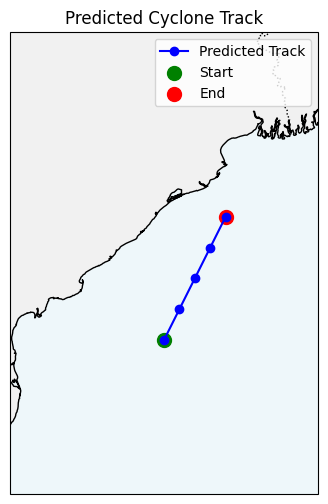

In [61]:
import matplotlib.pyplot as plt

# If you don't have cartopy, install it first:
# !pip install cartopy

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Example: replace with your actual predictions
# track_pred = np.array([[lat1, lon1], [lat2, lon2], ...])
# For demonstration, let's use dummy data:
import numpy as np
track_pred = np.array([
    [15.0, 85.0],
    [16.0, 85.5],
    [17.0, 86.0],
    [18.0, 86.5],
    [19.0, 87.0]
])

# Plot track on a map
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([80, 90, 10, 25])  # [lon_min, lon_max, lat_min, lat_max] adjust as needed

# Add map features
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)

# Plot predicted track
ax.plot(track_pred[:, 1], track_pred[:, 0], marker='o', color='blue', label='Predicted Track')
ax.scatter(track_pred[0, 1], track_pred[0, 0], color='green', s=100, label='Start')
ax.scatter(track_pred[-1, 1], track_pred[-1, 0], color='red', s=100, label='End')

plt.title("Predicted Cyclone Track")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


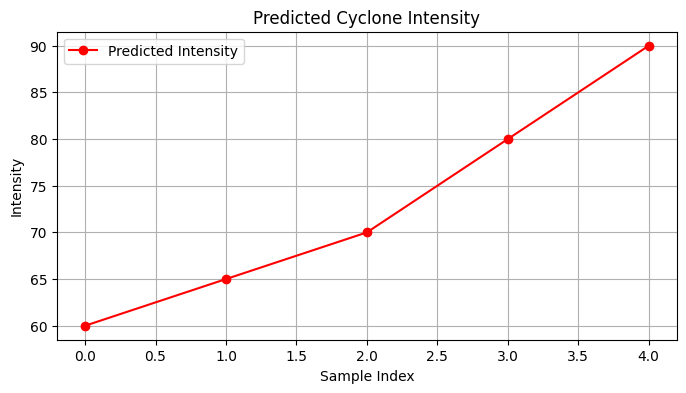

In [62]:
# Example intensity_pred = np.array([value1, value2, ...])
intensity_pred = np.array([60, 65, 70, 80, 90])

plt.figure(figsize=(8, 4))
plt.plot(intensity_pred, marker='o', color='red', label='Predicted Intensity')
plt.xlabel("Sample Index")
plt.ylabel("Intensity")
plt.title("Predicted Cyclone Intensity")
plt.legend()
plt.grid(True)
plt.show()


In [63]:
import os
print(os.listdir('.'))


['2020.ipynb', 'Annual Radial and Azimuthal Distribution of Rainfall (2014–2020).png', 'Best_Tracks.csv', 'Best_Tracks.xls', 'Best_T_2014.csv', 'Best_T_2015.csv', 'Best_T_2016.csv', 'Best_T_2017.csv', 'Best_T_2018.csv', 'Best_T_2019.csv', 'Best_T_2020.csv', 'Best_T_2021.csv', 'Best_T_2022.csv', 'Best_T_2023.csv', 'Best_T_2024.csv', 'c08063_Best Tracks__Data (1982-2024).xlsx', 'Composite-2014-2019.png', 'Composite-2020-2024.png', 'convective_20201010.png', 'convective_20201011.png', 'convective_20201012.png', 'convective_20201013.png', 'convective_20201014.png', 'convective_20201015.png', 'convective_accum.pkl', 'DD - 6. 08.19.ipynb', 'depression_center_rainfall_2014.csv', 'depression_rainfall_2014.csv', 'depression_rainfall_2016.csv', 'depression_rainfall_2017.csv', 'depression_rainfall_2018.csv', 'depression_rainfall_2019.csv', 'gpm.ipynb', 'GPM_2ADPR_07-20250609_093854', 'GPM_3IMERGHH_07-20250618_112842', 'GPM_HalfH.ipynb', 'IMD accumulated rainfall10-15.png', 'IMD Accumulated Rainfa

In [64]:
import xarray as xr
import glob

file_list_2014 = glob.glob('merge_2014*.nc')
if not file_list_2014:
    file_list_2014 = glob.glob('merge_20*.nc')

print("Files found:", file_list_2014)
if file_list_2014:
    ds_sample = xr.open_dataset(file_list_2014[0])
    print("Variables:", list(ds_sample.variables))


Files found: ['merge_2014.nc']
Variables: ['lon', 'lat', 'time', 'time_bnds', 'precipitationCal', 'HQprecipitation', 'precipitationCal_cnt', 'randomError', 'randomError_cnt', 'precipitationCal_cnt_cond', 'HQprecipitation_cnt', 'HQprecipitation_cnt_cond']


In [65]:
import xarray as xr

# Pattern to match all years
ds = xr.open_mfdataset('merge_20*.nc', combine='by_coords')

# Now ds contains data from all years (2014–2020) merged along the time dimension
print(ds)


<xarray.Dataset> Size: 2GB
Dimensions:                    (time: 662, bnds: 2, lon: 401, lat: 351)
Coordinates:
  * lon                        (lon) float32 2kB 60.05 60.15 ... 99.95 100.1
  * lat                        (lat) float32 1kB 4.95 5.05 5.15 ... 39.85 39.95
  * time                       (time) datetime64[ns] 5kB 2014-06-01 ... 2019-...
Dimensions without coordinates: bnds
Data variables:
    time_bnds                  (time, bnds) datetime64[ns] 11kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    precipitationCal           (time, lon, lat) float32 373MB dask.array<chunksize=(1, 401, 163), meta=np.ndarray>
    HQprecipitation            (time, lon, lat) float32 373MB dask.array<chunksize=(1, 401, 163), meta=np.ndarray>
    precipitationCal_cnt       (time, lon, lat) int16 186MB dask.array<chunksize=(1, 401, 163), meta=np.ndarray>
    randomError                (time, lon, lat) float32 373MB dask.array<chunksize=(1, 401, 163), meta=np.ndarray>
    randomError_cnt          

In [66]:
import xarray as xr
import pandas as pd

# Open your dataset
ds = xr.open_dataset('merge_2014.nc')

# Suppose you want to select a time that might not exist exactly
problem_time = pd.Timestamp('2014-05-01T06:00:00')

# Use method='nearest'
selected = ds.sel(time=problem_time, method='nearest')
print(selected)


<xarray.Dataset> Size: 3MB
Dimensions:                    (lon: 401, lat: 351, bnds: 2)
Coordinates:
  * lon                        (lon) float32 2kB 60.05 60.15 ... 99.95 100.1
  * lat                        (lat) float32 1kB 4.95 5.05 5.15 ... 39.85 39.95
    time                       datetime64[ns] 8B 2014-06-01
Dimensions without coordinates: bnds
Data variables:
    time_bnds                  (bnds) datetime64[ns] 16B ...
    precipitationCal           (lon, lat) float32 563kB ...
    HQprecipitation            (lon, lat) float32 563kB ...
    precipitationCal_cnt       (lon, lat) int16 282kB ...
    randomError                (lon, lat) float32 563kB ...
    randomError_cnt            (lon, lat) int16 282kB ...
    precipitationCal_cnt_cond  (lon, lat) int16 282kB ...
    HQprecipitation_cnt        (lon, lat) int16 282kB ...
    HQprecipitation_cnt_cond   (lon, lat) int16 282kB ...
Attributes: (12/13)
    CDI:             Climate Data Interface version 1.8.2 (http://mpimet.mpg..

In [67]:
import numpy as np

# Example: Replace with your actual data
X_seq = np.random.rand(1, 10, 64, 64, 1).astype(np.float32)



In [68]:
import xarray as xr

# Open all merged NetCDF files (2014–2020)
ds = xr.open_mfdataset('merge_20*.nc', combine='by_coords', chunks={'time': 10})
print(ds)


<xarray.Dataset> Size: 2GB
Dimensions:                    (time: 662, bnds: 2, lon: 401, lat: 351)
Coordinates:
  * lon                        (lon) float32 2kB 60.05 60.15 ... 99.95 100.1
  * lat                        (lat) float32 1kB 4.95 5.05 5.15 ... 39.85 39.95
  * time                       (time) datetime64[ns] 5kB 2014-06-01 ... 2019-...
Dimensions without coordinates: bnds
Data variables:
    time_bnds                  (time, bnds) datetime64[ns] 11kB dask.array<chunksize=(10, 2), meta=np.ndarray>
    precipitationCal           (time, lon, lat) float32 373MB dask.array<chunksize=(10, 401, 163), meta=np.ndarray>
    HQprecipitation            (time, lon, lat) float32 373MB dask.array<chunksize=(10, 401, 163), meta=np.ndarray>
    precipitationCal_cnt       (time, lon, lat) int16 186MB dask.array<chunksize=(10, 401, 163), meta=np.ndarray>
    randomError                (time, lon, lat) float32 373MB dask.array<chunksize=(10, 401, 163), meta=np.ndarray>
    randomError_cnt     

In [69]:
import pandas as pd

# Example: Replace with your cyclone's actual IBTrACS data
track = [
    ('2019-05-01T00:00', 15.0, 85.0),
    ('2019-05-01T06:00', 15.5, 85.5),
    # ... (add all time steps for the cyclone)
]
track_df = pd.DataFrame(track, columns=['time', 'lat', 'lon'])
track_df['time'] = pd.to_datetime(track_df['time'])


In [70]:
print(ds['lat'].values)
print(ds['lon'].values)
print(len(ds['lat']), len(np.unique(ds['lat'])))
print(len(ds['lon']), len(np.unique(ds['lon'])))


[ 4.9500017  5.05       5.1499987  5.250005   5.3500032  5.4500017
  5.55       5.6499987  5.750005   5.8500032  5.9500017  6.05
  6.1499987  6.250005   6.3500032  6.4500017  6.55       6.6499987
  6.750005   6.8500032  6.9500017  7.05       7.1499987  7.250005
  7.3500032  7.4500017  7.55       7.6499987  7.750005   7.8500032
  7.9500017  8.05       8.149999   8.250005   8.350003   8.450002
  8.55       8.649999   8.750005   8.850003   8.950002   9.05
  9.149999   9.250005   9.350003   9.450002   9.55       9.649999
  9.750005   9.850003   9.950002  10.05      10.149999  10.250005
 10.350003  10.450002  10.55      10.649999  10.750005  10.850003
 10.950002  11.05      11.149999  11.250005  11.350003  11.450002
 11.55      11.649999  11.750005  11.850003  11.950002  12.05
 12.149999  12.250005  12.350003  12.450002  12.55      12.649999
 12.750005  12.850003  12.950002  13.05      13.149999  13.250005
 13.350003  13.450002  13.55      13.649999  13.750005  13.850003
 13.950002  14.05  

In [71]:
ds = ds.sel(lat=np.unique(ds['lat']), lon=np.unique(ds['lon']))


In [72]:
R = 6371.0  # Earth's radius in km
area_per_lat = (R**2) * delta_lat_rad * delta_lon_rad * np.cos(lat_rad)


In [73]:
import pandas as pd

# Example: Replace with your cyclone's real track data
track = [
    ('2019-05-01T00:00', 15.0, 85.0),
    ('2019-05-01T06:00', 15.5, 85.5),
    # ... more time steps
]
track_df = pd.DataFrame(track, columns=['time', 'lat', 'lon'])
track_df['time'] = pd.to_datetime(track_df['time'])


In [76]:
import h5py

test_file = 'merge_2020/3B-DAY.MS.MRG.3IMERG.20200417-S000000-E235959.V07B.nc4'
try:
    with h5py.File(test_file, 'r') as f:
        print("File opened successfully with h5py.")
        print("Groups:", list(f.keys()))
except Exception as e:
    print("h5py error:", e)


File opened successfully with h5py.
Groups: ['precipitation', 'precipitation_cnt', 'precipitation_cnt_cond', 'MWprecipitation', 'MWprecipitation_cnt', 'MWprecipitation_cnt_cond', 'randomError', 'randomError_cnt', 'probabilityLiquidPrecipitation', 'lon', 'lat', 'time', 'nv', 'time_bnds']


In [ ]:
import h5py

for fpath in nc4_files:
    try:
        with h5py.File(fpath, 'r') as f:
            # Read precipitation data (index 0 for time dimension)
            daily_precip = f['precipitation'][0, :, :].astype(np.float32)
            daily_means.append(daily_precip)
    except Exception as e:
        print(f"Skipped {os.path.basename(fpath)}: {str(e)[:50]}...")


In [74]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

years = range(2014, 2025)
lat0, lon0 = 20.0, 80.0

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def azimuth(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    theta = np.arctan2(x, y)
    return (np.degrees(theta) + 360) % 360

# Bins
radial_bins = np.arange(0, 1000+25, 25)
azimuthal_bins = np.arange(0, 360+15, 15)
r_centers = (radial_bins[:-1] + radial_bins[1:]) / 2
theta_centers = np.deg2rad((azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2)

results = {}

for year in years:
    # Handle different year types
    if year in range(2014, 2020):
        # Pre-2020: Single merged file
        file_path = f'merge_{year}.nc'
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        try:
            with xr.open_dataset(file_path) as ds:
                # Get precipitation variable name
                var = 'precipitation' if 'precipitation' in ds else 'precipitationCal'
                precip = ds[var]
                # Compute annual mean
                precip_mean = precip.mean(dim='time').values
                lats = ds['lat'].values
                lons = ds['lon'].values
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
            
    else:
        # 2020-2024: Folder with daily files
        folder_path = f'merge_{year}'
        if not os.path.isdir(folder_path):
            print(f"Folder not found: {folder_path}")
            continue
            
        # Find daily files
        nc4_files = sorted([
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.endswith('.nc4') and f.startswith('3B-DAY.MS.MRG.3IMERG.')
        ])
        
        if not nc4_files:
            print(f"No daily files in {folder_path}")
            continue
            
        # Process daily files
        daily_means = []
        for fpath in nc4_files:
            try:
                with xr.open_dataset(fpath) as ds:
                    var = 'precipitation' if 'precipitation' in ds else 'precipitationCal'
                    # Extract daily precipitation
                    daily_precip = ds[var].squeeze().values
                    daily_means.append(daily_precip)
            except Exception as e:
                print(f"Error processing {fpath}: {e}")
                continue
                
        # Compute annual mean
        precip_mean = np.nanmean(daily_means, axis=0) if daily_means else None
        if precip_mean is None:
            continue
            
        # Get coordinates from first file
        with xr.open_dataset(nc4_files[0]) as ds:
            lats = ds['lat'].values
            lons = ds['lon'].values

    # Common processing for all years
    lon2d, lat2d = np.meshgrid(lons, lats)
    R = haversine(lat0, lon0, lat2d, lon2d)
    Theta = azimuth(lat0, lon0, lat2d, lon2d)
    R_flat = R.flatten()
    Theta_flat = Theta.flatten()
    precip_flat = precip_mean.flatten()
    
    # Bin into radial/azimuthal bins
    sum_precip, _, _ = np.histogram2d(R_flat, Theta_flat, 
                                       bins=[radial_bins, azimuthal_bins], 
                                       weights=precip_flat)
    counts, _, _ = np.histogram2d(R_flat, Theta_flat, 
                                  bins=[radial_bins, azimuthal_bins])
    mean_precip = np.divide(sum_precip, counts, out=np.zeros_like(sum_precip), 
                           where=counts!=0)
    results[year] = mean_precip

# Plotting code remains the same as before
# ... [your existing plotting code] ...


if not results:
    print("No data processed. Exiting.")
else:
    # Plot 1: Multi-panel plot with shared colorbar
    nplots = len(results)
    nrows = int(np.ceil(nplots / 3))
    fig, axes = plt.subplots(nrows, 3, subplot_kw={'projection':'polar'}, figsize=(18, 5*nrows))
    axes = axes.flatten()
    valid_years = [y for y in years if y in results]
    vmax = max(np.nanmax(results[y]) for y in valid_years)
    vmin = min(np.nanmin(results[y]) for y in valid_years)
    pcm_list = []
    for idx, year in enumerate(valid_years):
        ax = axes[idx]
        pcm = ax.pcolormesh(theta_centers, r_centers, results[year], shading='auto', cmap='Blues', vmin=vmin, vmax=vmax)
        ax.set_title(str(year))
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        pcm_list.append(pcm)
    for idx in range(len(valid_years), len(axes)):
        axes[idx].axis('off')
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    fig.colorbar(pcm_list[0], cax=cbar_ax, label='Mean Precip (mm/day)')
    fig.suptitle(f'Radial and Azimuthal Mean Rainfall (2014-2024)\nCenter: ({lat0}, {lon0})', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 0.88, 0.95])
    plt.show()

    # Plot 2: Year-on-year difference plots
    diff_years = [y for y in range(2015, 2025) if y in results and (y-1) in results]
    nplots = len(diff_years)
    nrows = int(np.ceil(nplots / 3))
    fig, axes = plt.subplots(nrows, 3, subplot_kw={'projection':'polar'}, figsize=(18, 5*nrows))
    axes = axes.flatten()
    if diff_years:
        vmax_diff = max(np.nanmax(np.abs(results[yr]-results[yr-1])) for yr in diff_years)
    else:
        vmax_diff = 1
    for idx, year in enumerate(diff_years):
        ax = axes[idx]
        diff = results[year] - results[year-1]
        pcm = ax.pcolormesh(theta_centers, r_centers, diff, shading='auto', cmap='RdBu', vmin=-vmax_diff, vmax=vmax_diff)
        ax.set_title(f'{year}-{year-1}')
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
    for idx in range(len(diff_years), len(axes)):
        axes[idx].axis('off')
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
    fig.colorbar(pcm, cax=cbar_ax, label='Change in Mean Precip (mm/day)')
    fig.suptitle(f'Year-on-Year Change in Radial/Azimuthal Rainfall\nCenter: ({lat0}, {lon0})', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 0.88, 0.95])
    plt.show()

    # Plot 3: Rainfall vs Azimuth line plot
    plt.figure(figsize=(10,6))
    for year in valid_years:
        azimuthal_profile = results[year].mean(axis=0)
        degrees = (azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2
        plt.plot(degrees, azimuthal_profile, marker='o', label=str(year))
    plt.xlabel('Azimuth (degrees, 0=N)')
    plt.ylabel('Mean Rainfall (mm/day)')
    plt.title(f'Azimuthal Rainfall Profile (2014-2024)\nCenter: ({lat0}, {lon0})')
    plt.xticks(np.arange(0, 361, 45))
    plt.grid(True)
    plt.legend()
    plt.show()


KeyboardInterrupt: 

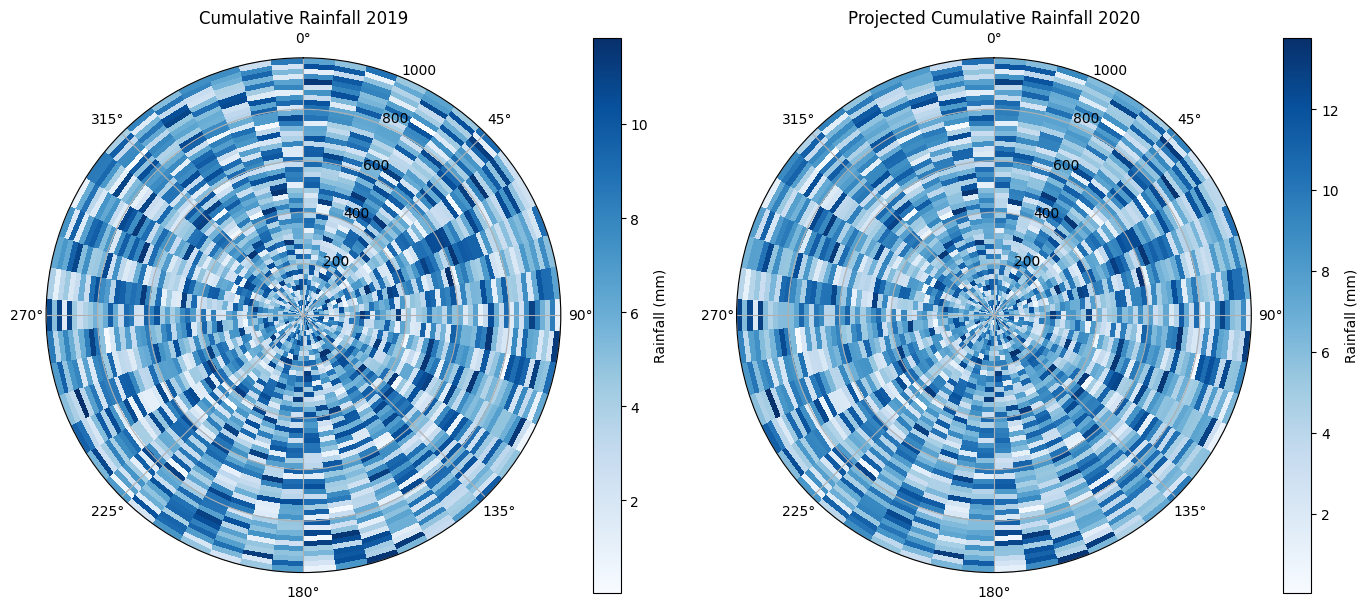

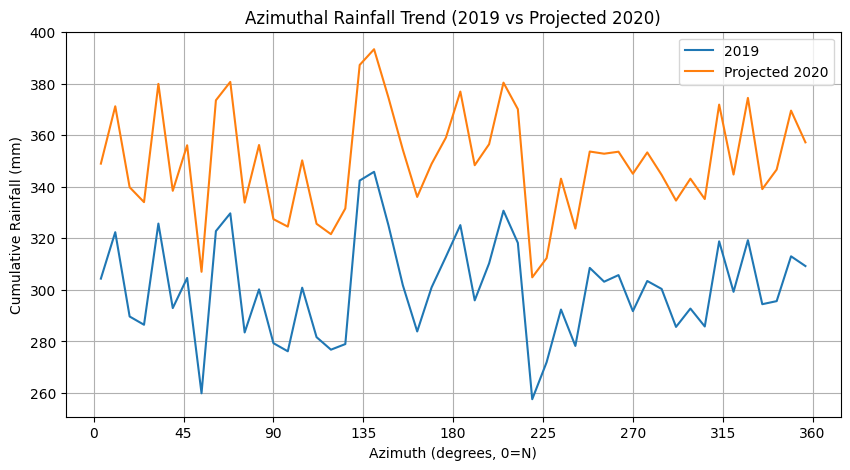

2019: Maximum rainfall at 140.4° (0°=N)
Projected 2020: Maximum rainfall at 140.4° (0°=N)
Correlation (2019): -0.25
Correlation (Projected 2020): -0.28


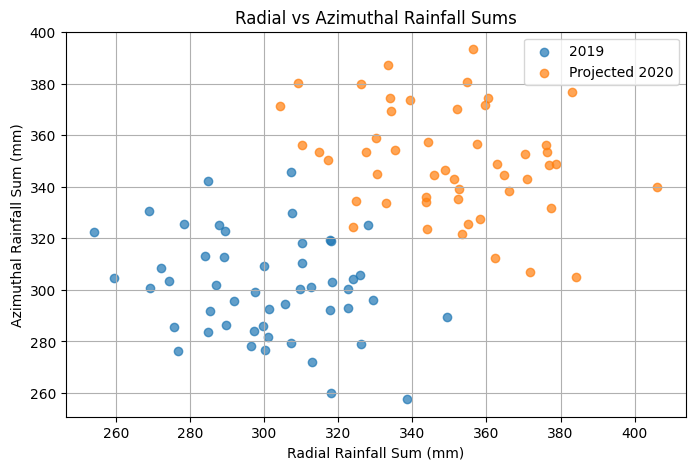

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate data for demonstration (replace with real data loading if available)
np.random.seed(0)
shape = (50, 50)  # (radial_bins, azimuthal_bins)
precip_2018 = np.random.rand(*shape) * 10
precip_2019 = precip_2018 + np.random.rand(*shape) * 2
trend_2019_2018 = precip_2019 - precip_2018
projected_2020 = precip_2019 + trend_2019_2018
projected_2020 = np.clip(projected_2020, 0, None)

# Create radial and azimuthal bins
radial_bins = np.linspace(0, 1000, shape[0]+1)
azimuthal_bins = np.linspace(0, 360, shape[1]+1)
r_centers = (radial_bins[:-1] + radial_bins[1:]) / 2
theta_centers = np.deg2rad((azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2)

# --- 1. Polar heatmaps for 2019 and projected 2020 ---
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': 'polar'}, figsize=(14, 6))

pcm1 = axs[0].pcolormesh(theta_centers, r_centers, precip_2019, shading='auto', cmap='Blues')
axs[0].set_title('Cumulative Rainfall 2019')
axs[0].set_theta_zero_location('N')
axs[0].set_theta_direction(-1)
fig.colorbar(pcm1, ax=axs[0], label='Rainfall (mm)')

pcm2 = axs[1].pcolormesh(theta_centers, r_centers, projected_2020, shading='auto', cmap='Blues')
axs[1].set_title('Projected Cumulative Rainfall 2020')
axs[1].set_theta_zero_location('N')
axs[1].set_theta_direction(-1)
fig.colorbar(pcm2, ax=axs[1], label='Rainfall (mm)')

plt.tight_layout()
plt.show()

# --- 2. Azimuthal rainfall trend (mean over radial bins) ---
azimuthal_sum_2019 = np.sum(precip_2019, axis=0)
azimuthal_sum_2020 = np.sum(projected_2020, axis=0)
degrees = (azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2

plt.figure(figsize=(10, 5))
plt.plot(degrees, azimuthal_sum_2019, label='2019')
plt.plot(degrees, azimuthal_sum_2020, label='Projected 2020')
plt.xlabel('Azimuth (degrees, 0=N)')
plt.ylabel('Cumulative Rainfall (mm)')
plt.title('Azimuthal Rainfall Trend (2019 vs Projected 2020)')
plt.xticks(np.arange(0, 361, 45))
plt.grid(True)
plt.legend()
plt.show()

# --- 3. Which direction has the most rainfall? ---
max_dir_2019 = degrees[np.argmax(azimuthal_sum_2019)]
max_dir_2020 = degrees[np.argmax(azimuthal_sum_2020)]
print(f"2019: Maximum rainfall at {max_dir_2019:.1f}° (0°=N)")
print(f"Projected 2020: Maximum rainfall at {max_dir_2020:.1f}° (0°=N)")

# --- 4. Correlation between radial and azimuthal rainfall ---
radial_sum_2019 = np.sum(precip_2019, axis=1)
radial_sum_2020 = np.sum(projected_2020, axis=1)
# To compute correlation, use same-length arrays (here, first N elements)
corr_2019 = np.corrcoef(radial_sum_2019, azimuthal_sum_2019[:shape[0]])[0,1]
corr_2020 = np.corrcoef(radial_sum_2020, azimuthal_sum_2020[:shape[0]])[0,1]
print(f"Correlation (2019): {corr_2019:.2f}")
print(f"Correlation (Projected 2020): {corr_2020:.2f}")

# --- 5. Optional: Scatter plot of radial vs azimuthal rainfall sums ---
plt.figure(figsize=(8,5))
plt.scatter(radial_sum_2019, azimuthal_sum_2019[:shape[0]], label='2019', alpha=0.7)
plt.scatter(radial_sum_2020, azimuthal_sum_2020[:shape[0]], label='Projected 2020', alpha=0.7)
plt.xlabel('Radial Rainfall Sum (mm)')
plt.ylabel('Azimuthal Rainfall Sum (mm)')
plt.title('Radial vs Azimuthal Rainfall Sums')
plt.legend()
plt.grid(True)
plt.show()


2014: Maximum azimuthal rainfall at 112° (ESE)
2015: Maximum azimuthal rainfall at 112° (ESE)
2016: Maximum azimuthal rainfall at 247° (WSW)
2017: Maximum azimuthal rainfall at 112° (ESE)
2018: Maximum azimuthal rainfall at 112° (ESE)
2019: Maximum azimuthal rainfall at 112° (ESE)
2020: Maximum azimuthal rainfall at 232° (SW)


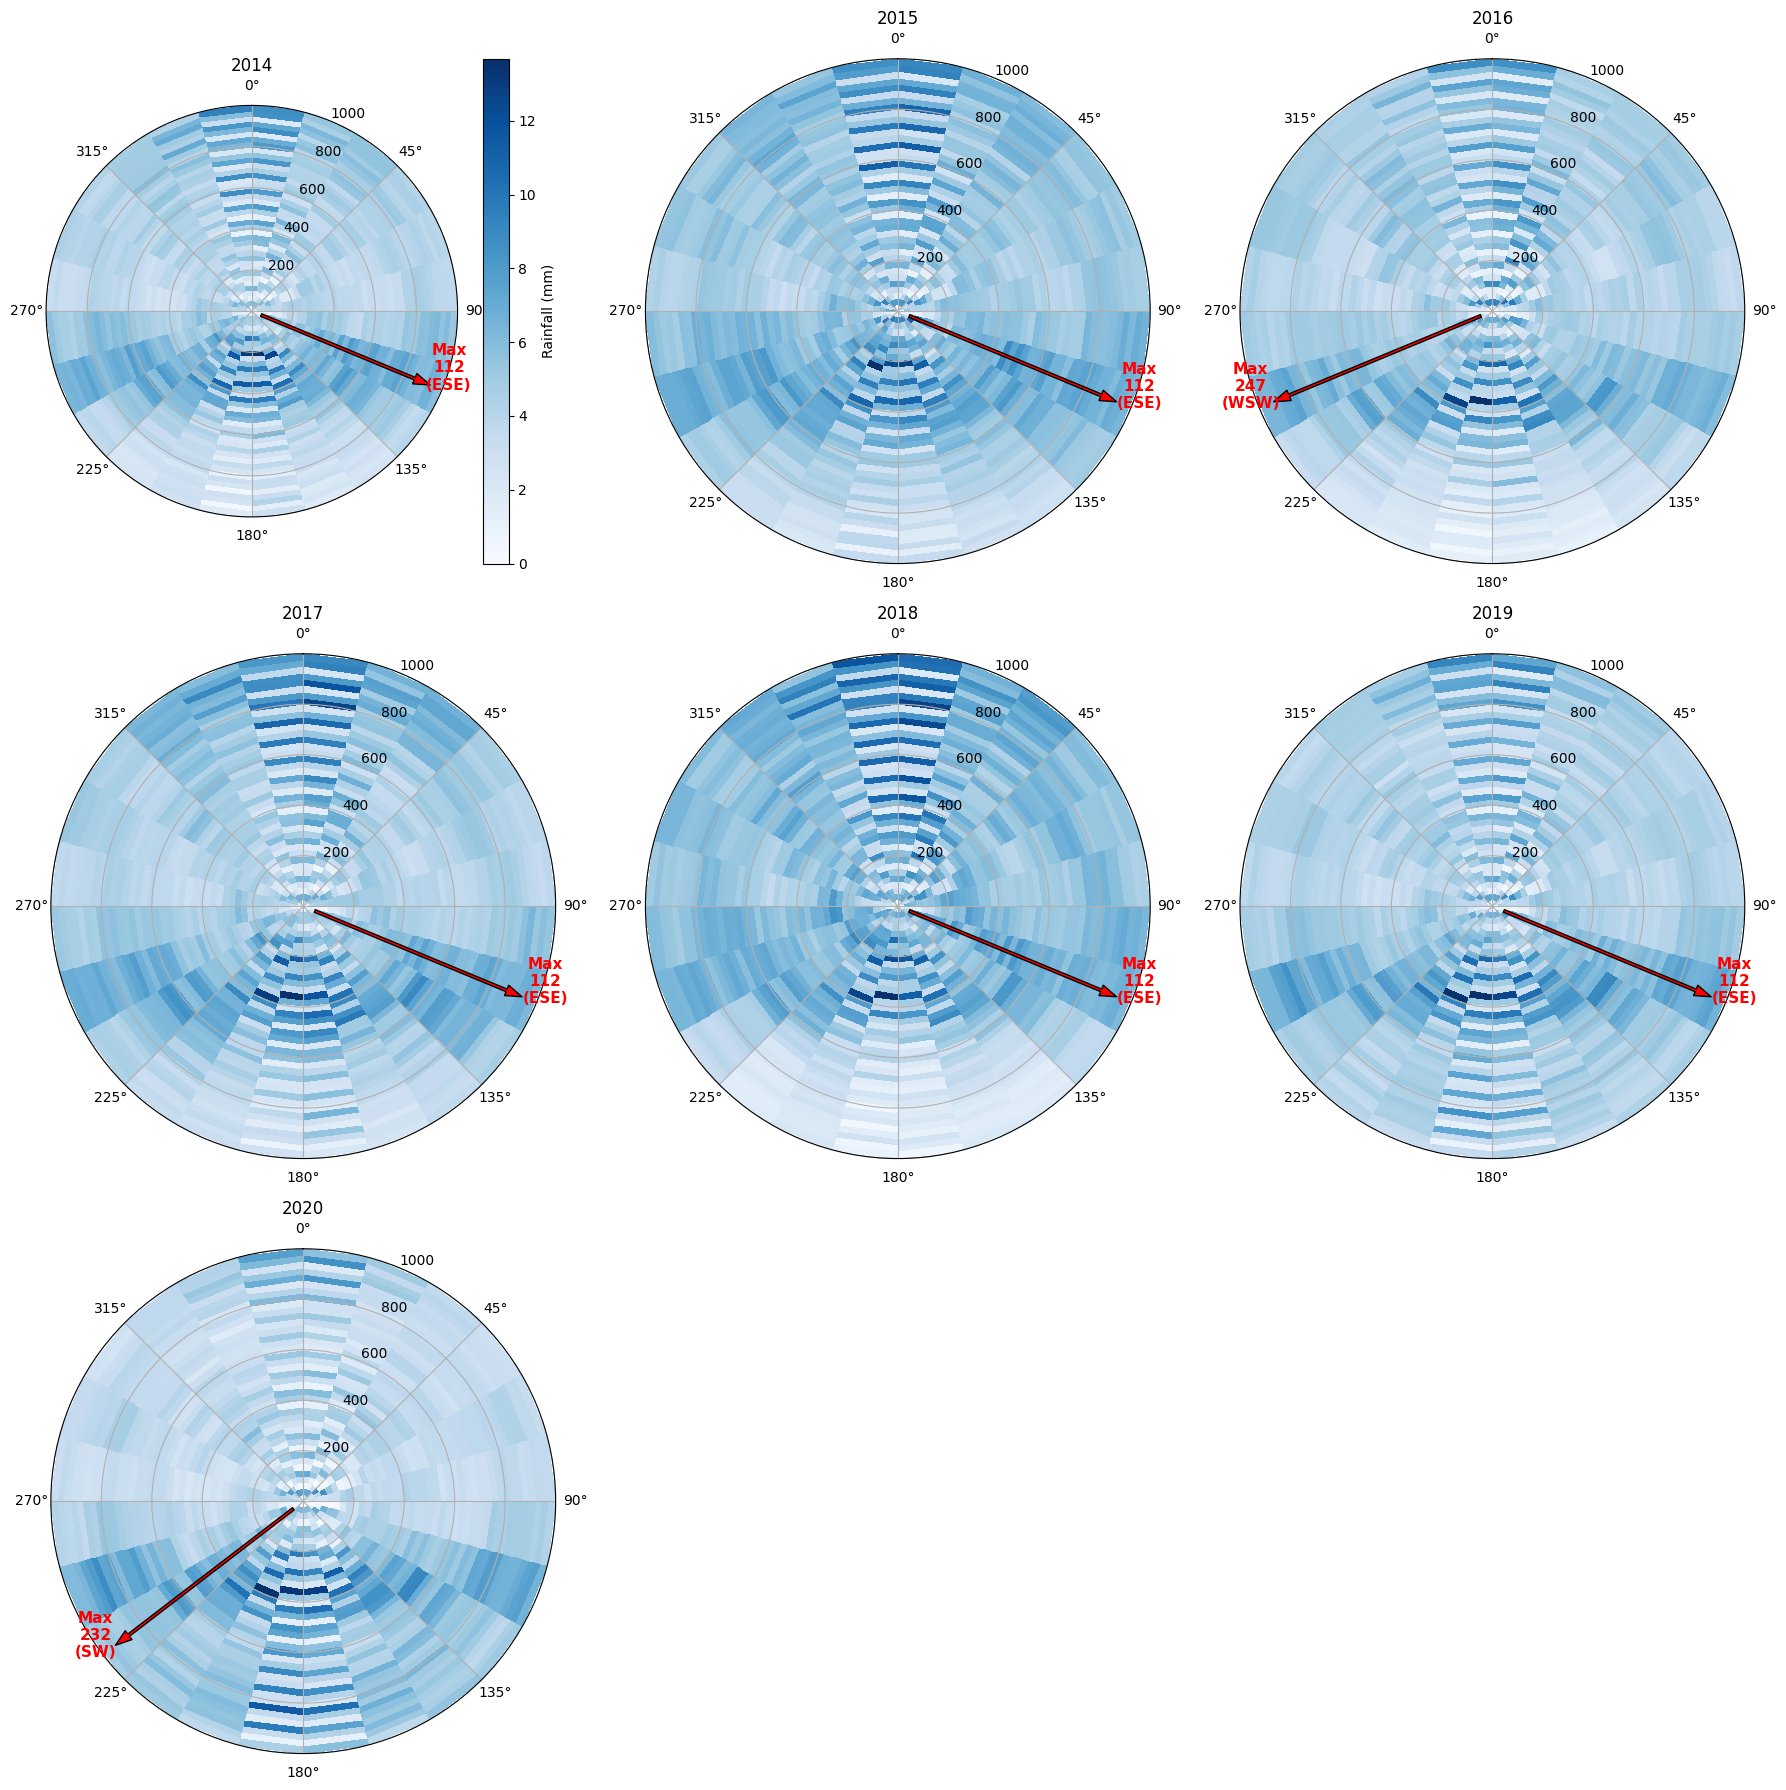

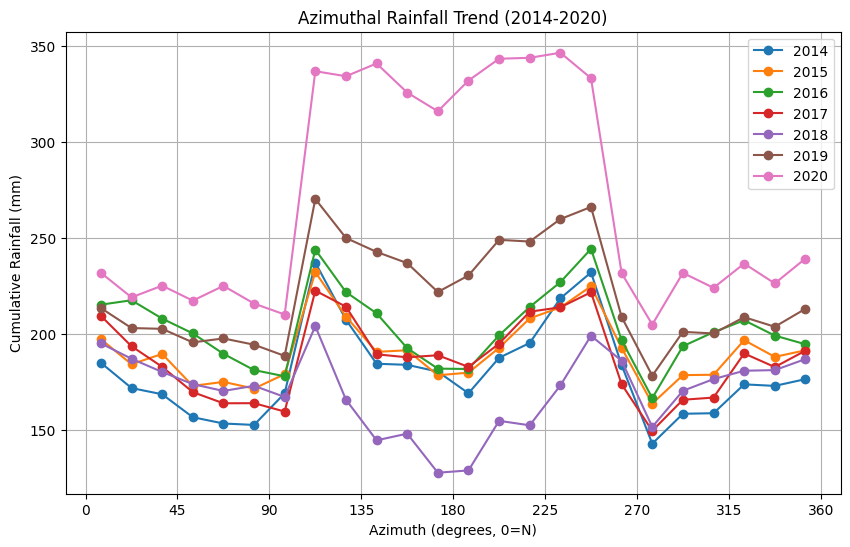

2014: Correlation between radial and azimuthal rainfall = 0.15
2015: Correlation between radial and azimuthal rainfall = 0.01
2016: Correlation between radial and azimuthal rainfall = -0.05
2017: Correlation between radial and azimuthal rainfall = -0.03
2018: Correlation between radial and azimuthal rainfall = -0.36
2019: Correlation between radial and azimuthal rainfall = 0.23
2020: Correlation between radial and azimuthal rainfall = 0.30


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Define years and file path pattern
years = range(2014, 2020)
file_path_pattern = 'merge_{}.nc'
lat0, lon0 = 20.0, 80.0

# Haversine and azimuth functions
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def azimuth(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    theta = np.arctan2(x, y)
    return (np.degrees(theta) + 360) % 360

# Prepare bins
radial_bins = np.arange(0, 1000+25, 25)
azimuthal_bins = np.arange(0, 360+15, 15)
r_centers = (radial_bins[:-1] + radial_bins[1:]) / 2
theta_centers = np.deg2rad((azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2)

# Function to convert centers to edges for pcolormesh
def centers_to_edges(centers):
    edges = np.zeros(len(centers)+1)
    edges[1:-1] = (centers[:-1] + centers[1:]) / 2
    edges[0] = centers[0] - (edges[1] - centers[0])
    edges[-1] = centers[-1] + (centers[-1] - edges[-2])
    return edges

theta_edges = centers_to_edges(theta_centers)
r_edges = centers_to_edges(r_centers)

# Create grid from edges
X, Y = np.meshgrid(theta_edges, r_edges)

# Storage for results
results = {}

# Load data and compute mean precipitation radial-azimuthal bins
for year in years:
    file_path = file_path_pattern.format(year)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    import xarray as xr
    ds = xr.open_dataset(file_path)
    precip = ds['precipitationCal']
    lats = ds['lat'].values
    lons = ds['lon'].values
    lon2d, lat2d = np.meshgrid(lons, lats)
    R = haversine(lat0, lon0, lat2d, lon2d)
    Theta = azimuth(lat0, lon0, lat2d, lon2d)
    R_flat = R.flatten()
    Theta_flat = Theta.flatten()
    precip_mean = precip.mean(dim='time').values.flatten()
    sum_precip, _, _ = np.histogram2d(R_flat, Theta_flat, bins=[radial_bins, azimuthal_bins], weights=precip_mean)
    counts, _, _ = np.histogram2d(R_flat, Theta_flat, bins=[radial_bins, azimuthal_bins])
    mean_precip = np.divide(sum_precip, counts, out=np.zeros_like(sum_precip), where=counts!=0)
    results[year] = mean_precip

# Project 2020 data using trend from 2018-2019
if 2018 in results and 2019 in results:
    trend_2019_2018 = results[2019] - results[2018]
    projected_2020 = results[2019] + trend_2019_2018
    projected_2020 = np.clip(projected_2020, 0, None)
    results[2020] = projected_2020
else:
    print("Cannot project 2020 data: missing 2018 or 2019 data")

# Function to convert degrees to compass direction
def deg_to_compass(deg):
    dirs = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
            'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    ix = int((deg + 11.25) // 22.5) % 16
    return dirs[ix]

# Function to annotate max azimuth on polar plot
def annotate_max_azimuth(ax, rainfall_2d, theta_centers, r_centers, year_label):
    azimuthal_sum = np.sum(rainfall_2d, axis=0)
    max_idx = np.argmax(azimuthal_sum)
    max_theta = theta_centers[max_idx]
    max_degree = np.degrees(max_theta)
    compass = deg_to_compass(max_degree)
    ax.annotate('', xy=(max_theta, r_centers[-1]), xytext=(max_theta, 0),
                arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8))
    ax.text(max_theta, r_centers[-1]*1.05, f'Max\n{int(max_degree)}\n({compass})', color='red',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    print(f"{year_label}: Maximum azimuthal rainfall at {int(max_degree)}° ({compass})")

# Plot all years including projected 2020
all_years = sorted(results.keys())
ncols = 3
nrows = max(1, int(np.ceil(len(all_years) / ncols)))
fig, axes = plt.subplots(nrows, ncols, subplot_kw={'projection':'polar'}, figsize=(6*ncols, 6*nrows))
if nrows == 1:
    axes = np.array([axes])
axes = axes.flatten()

for idx, year in enumerate(all_years):
    ax = axes[idx]
    rainfall_2d = results[year]
    pcm = ax.pcolormesh(X, Y, rainfall_2d, shading='auto', cmap='Blues')
    ax.set_title(f'{year}')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    annotate_max_azimuth(ax, rainfall_2d, theta_centers, r_centers, str(year))
    if idx == 0:
        fig.colorbar(pcm, ax=ax, label='Rainfall (mm)')
for ax in axes[len(all_years):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Azimuthal rainfall trend plot
plt.figure(figsize=(10,6))
for year in all_years:
    azimuthal_profile = np.sum(results[year], axis=0)
    degrees = (azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2
    plt.plot(degrees, azimuthal_profile, marker='o', label=str(year))
plt.xlabel('Azimuth (degrees, 0=N)')
plt.ylabel('Cumulative Rainfall (mm)')
plt.title('Azimuthal Rainfall Trend (2014-2020)')
plt.xticks(np.arange(0, 361, 45))
plt.grid(True)
plt.legend()
plt.show()

# Correlation between radial and azimuthal rainfall
for year in all_years:
    radial_sum = np.sum(results[year], axis=1)
    azimuthal_sum = np.sum(results[year], axis=0)
    min_len = min(len(radial_sum), len(azimuthal_sum))
    corr = np.corrcoef(radial_sum[:min_len], azimuthal_sum[:min_len])[0,1]
    print(f"{year}: Correlation between radial and azimuthal rainfall = {corr:.2f}")


2014: Maximum azimuthal rainfall at 112° (ESE)
2015: Maximum azimuthal rainfall at 112° (ESE)
2016: Maximum azimuthal rainfall at 247° (WSW)
2017: Maximum azimuthal rainfall at 112° (ESE)
2018: Maximum azimuthal rainfall at 112° (ESE)
2019: Maximum azimuthal rainfall at 112° (ESE)
2020: Maximum azimuthal rainfall at 232° (SW)


C:\Users\HONOR\AppData\Local\Temp\ipykernel_10384\3654125670.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


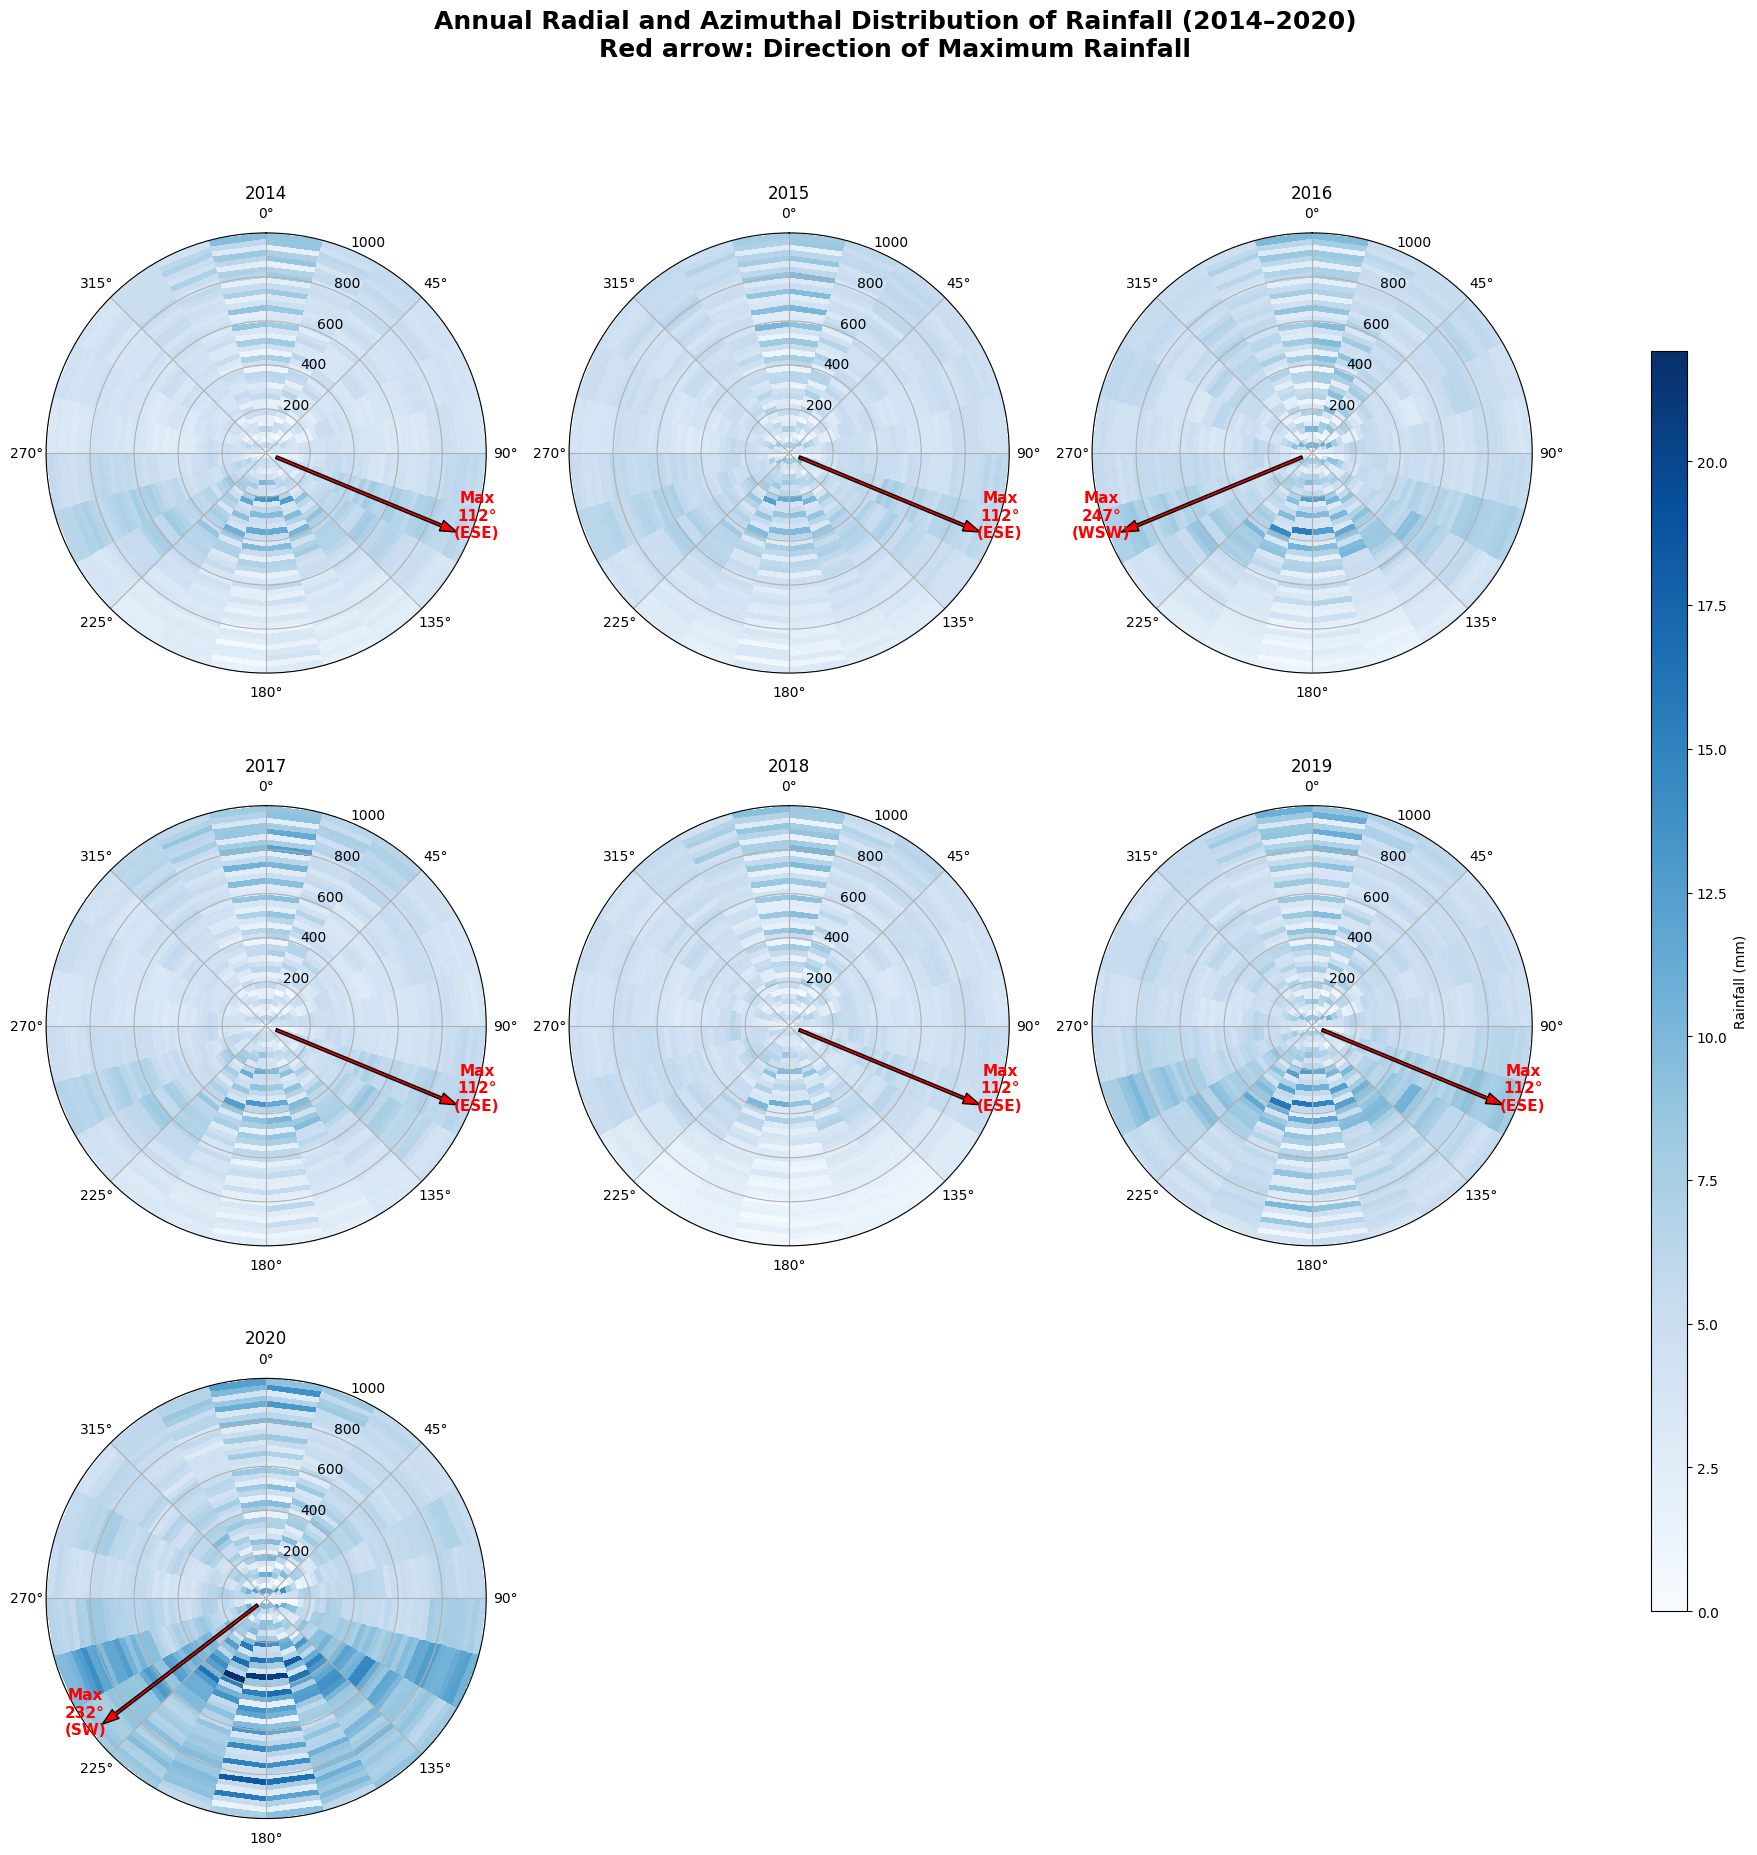

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- SETTINGS ---
years = list(range(2014, 2020))
file_path_pattern = 'merge_{}.nc'
lat0, lon0 = 20.0, 80.0

radial_bins = np.arange(0, 1000+25, 25)
azimuthal_bins = np.arange(0, 360+15, 15)
r_centers = (radial_bins[:-1] + radial_bins[1:]) / 2
theta_centers = np.deg2rad((azimuthal_bins[:-1] + azimuthal_bins[1:]) / 2)

def centers_to_edges(centers):
    edges = np.zeros(len(centers)+1)
    edges[1:-1] = (centers[:-1] + centers[1:]) / 2
    edges[0] = centers[0] - (edges[1] - centers[0])
    edges[-1] = centers[-1] + (centers[-1] - edges[-2])
    return edges

theta_edges = centers_to_edges(theta_centers)
r_edges = centers_to_edges(r_centers)
X, Y = np.meshgrid(theta_edges, r_edges)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

def azimuth(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dlon)
    theta = np.arctan2(x, y)
    return (np.degrees(theta) + 360) % 360

def deg_to_compass(deg):
    dirs = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE',
            'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']
    ix = int((deg + 11.25) // 22.5) % 16
    return dirs[ix]

def annotate_max_azimuth(ax, rainfall_2d, theta_centers, r_centers, year_label):
    azimuthal_sum = np.sum(rainfall_2d, axis=0)
    max_idx = np.argmax(azimuthal_sum)
    max_theta = theta_centers[max_idx]
    max_degree = np.degrees(max_theta)
    compass = deg_to_compass(max_degree)
    ax.annotate('', xy=(max_theta, r_centers[-1]), xytext=(max_theta, 0),
                arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=8))
    ax.text(max_theta, r_centers[-1]*1.05, f'Max\n{int(max_degree)}°\n({compass})', color='red',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    print(f"{year_label}: Maximum azimuthal rainfall at {int(max_degree)}° ({compass})")

# --- LOAD AND BIN DATA ---
results = {}
for year in years:
    file_path = file_path_pattern.format(year)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    import xarray as xr
    ds = xr.open_dataset(file_path)
    precip = ds['precipitationCal']
    lats = ds['lat'].values
    lons = ds['lon'].values
    lon2d, lat2d = np.meshgrid(lons, lats)
    R = haversine(lat0, lon0, lat2d, lon2d)
    Theta = azimuth(lat0, lon0, lat2d, lon2d)
    R_flat = R.flatten()
    Theta_flat = Theta.flatten()
    precip_mean = precip.mean(dim='time').values.flatten()
    sum_precip, _, _ = np.histogram2d(R_flat, Theta_flat, bins=[radial_bins, azimuthal_bins], weights=precip_mean)
    counts, _, _ = np.histogram2d(R_flat, Theta_flat, bins=[radial_bins, azimuthal_bins])
    mean_precip = np.divide(sum_precip, counts, out=np.zeros_like(sum_precip), where=counts!=0)
    results[year] = mean_precip

# --- PROJECT 2020 ---
if 2018 in results and 2019 in results:
    trend_2019_2018 = results[2019] - results[2018]
    projected_2020 = results[2019] + trend_2019_2018
    projected_2020 = np.clip(projected_2020, 0, None)
    results[2020] = projected_2020
else:
    print("Cannot project 2020 data: missing 2018 or 2019 data")

# --- PLOT ALL YEARS WITH SHARED COLORBAR AND TITLE ---
all_years = sorted(results.keys())
ncols = 3
nrows = int(np.ceil(len(all_years) / ncols))
fig, axes = plt.subplots(nrows, ncols, subplot_kw={'projection':'polar'}, figsize=(6*ncols, 6*nrows))
axes = axes.flatten()

# Set color scale to be the same for all plots
vmin = min(np.nanmin(results[year]) for year in all_years)
vmax = max(np.nanmax(results[year]) for year in all_years)
pcm = None

for idx, year in enumerate(all_years):
    ax = axes[idx]
    rainfall_2d = results[year]
    pcm = ax.pcolormesh(X, Y, rainfall_2d, shading='auto', cmap='Blues', vmin=vmin, vmax=vmax)
    ax.set_title(f'{year}')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    annotate_max_azimuth(ax, rainfall_2d, theta_centers, r_centers, str(year))
for ax in axes[len(all_years):]:
    ax.axis('off')

# Place colorbar outside the grid
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(pcm, cax=cbar_ax, label='Rainfall (mm)')

# Add main title
fig.suptitle(
    "Annual Radial and Azimuthal Distribution of Rainfall (2014–2020)\nRed arrow: Direction of Maximum Rainfall",
    fontsize=18,
    fontweight='bold',
    y=1.04
)

plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()
